# Course project

Done by Zolotarev Dmitriy (isu: 311791, group: R33353)

Variant: 9

## Preparation

In [24]:
import matplotlib.pyplot as plt
import control as ctrl
import sympy
import numpy as np
from sympy.utilities.lambdify import lambdify
import scipy
import cvxpy as cp
import array_to_latex as a2l

In [25]:
import seaborn as sns
sns.set_style("whitegrid")

color = ["#031B88", "#FB7B8E", "#AAB6FB", "#8A2BE2"]
sns.set_palette(color)

In [26]:
SAVE_PATH = 'latex/graphics'

def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

## System state space

In [27]:
M = 1
m = 1
g = 9.8
l = 1

In [28]:
A = np.array([
    [0, 1, 0, 0],
    [0, 0, m*g / M, 0],
    [0, 0, 0, 1],
    [0, 0, (M+m)*g / (M*l), 0]
])

B = np.array([
    [0],
    [1/M],
    [0],
    [1/(M*l)]
])

D = np.array([
    [0],
    [1/(M*l)],
    [0],
    [(M+m)/(M*m*l**2)]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

In [29]:
A

array([[ 0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  9.8,  0. ],
       [ 0. ,  0. ,  0. ,  1. ],
       [ 0. ,  0. , 19.6,  0. ]])

In [30]:
np.linalg.eigvals(A)

array([ 0.        ,  0.        ,  4.42718872, -4.42718872])

In [31]:
np.round(np.linalg.eig(A)[1],3)

array([[ 1.   , -1.   ,  0.099, -0.099],
       [ 0.   ,  0.   ,  0.436,  0.436],
       [ 0.   ,  0.   ,  0.197, -0.197],
       [ 0.   ,  0.   ,  0.872,  0.872]])

In [32]:
A_sym = sympy.Matrix(A)
B_sym = sympy.Matrix(B)
P, J = A_sym.jordan_form()
J

Matrix([
[0, 1.0,                 0,                0],
[0,   0,                 0,                0],
[0,   0, -4.42718872423573,                0],
[0,   0,                 0, 4.42718872423573]])

In [33]:
P

Matrix([
[1.0,   0, -0.112938487863156, 0.112938487863156],
[  0, 1.0,                0.5,               0.5],
[  0,   0, -0.225876975726313, 0.225876975726313],
[  0,   0,                1.0,               1.0]])

In [34]:
P.inv() @ B_sym

Matrix([
[  0],
[0.5],
[0.5],
[0.5]])

In [35]:
C @ P

Matrix([
[1.0, 0, -0.112938487863156, 0.112938487863156],
[  0, 0, -0.225876975726313, 0.225876975726313]])

In [36]:
np.linalg.matrix_rank(np.concatenate([A-(0)*np.identity(4),C]))

4

In [37]:
np.linalg.matrix_rank(np.concatenate([A-(-4.427188)*np.identity(4),B],axis=1))

4

In [38]:
sys_for_an = ctrl.ss(A, D, C ,np.zeros((2,1)))
sys_for_an_tf = ctrl.ss2tf(sys_for_an)
sys_for_an_tf

TransferFunction([[array([1.])], [array([2.])]], [[array([  1. ,  -0. , -19.6])], [array([  1. ,  -0. , -19.6])]])

In [39]:
sys_for_an = ctrl.ss(A, B, C ,np.zeros((2,1)))
sys_for_an_tf = ctrl.ss2tf(sys_for_an)
sys_for_an_tf

TransferFunction([[array([ 1.00000000e+00, -6.79456491e-15, -9.80000000e+00])], [array([1., 0., 0.])]], [[array([ 1.00000000e+00, -8.88178420e-16, -1.96000000e+01,  7.98013616e-15,
        3.64005795e-14])], [array([ 1.00000000e+00, -2.13337445e-16, -1.96000000e+01,  0.00000000e+00,
        0.00000000e+00])]])

In [40]:
np.sqrt(9.8)

3.1304951684997055

In [41]:
def up_func(t, x, u, params):
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
non_lin_sys = ctrl.NonlinearIOSystem(up_func)
non_lin_sys.set_inputs(2)

In [42]:
time_1 = np.linspace(0,2,int(2/0.001))

In [43]:
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=[0,0,0.05,0])
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=[0,0,0.05,0],U=np.zeros((2,len(time_1))))

Linear

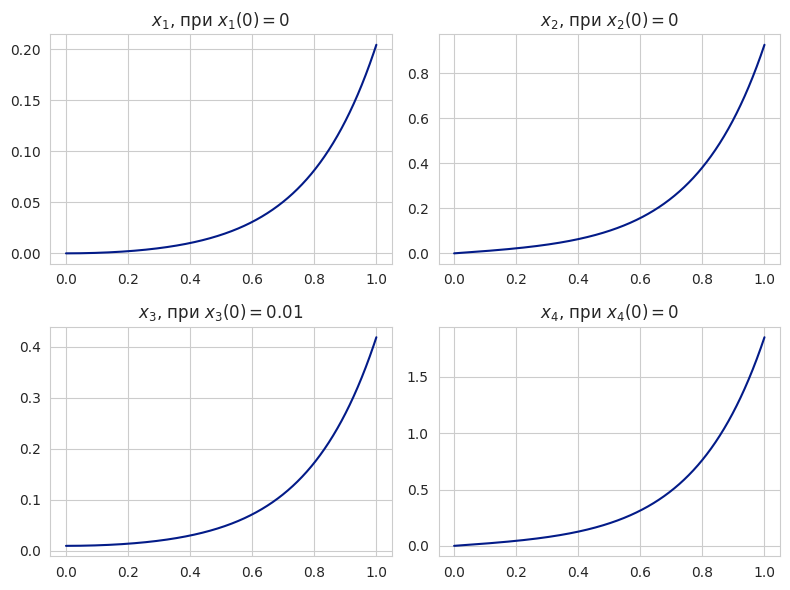

In [44]:
x0 = [0,0,0.01,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])
plt.tight_layout()

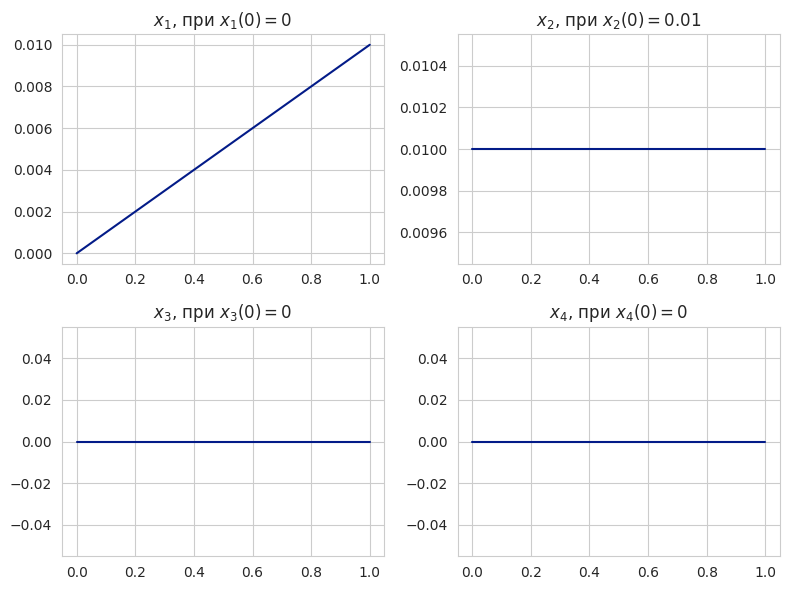

In [45]:
x0 = [0,0.01,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])
plt.tight_layout()

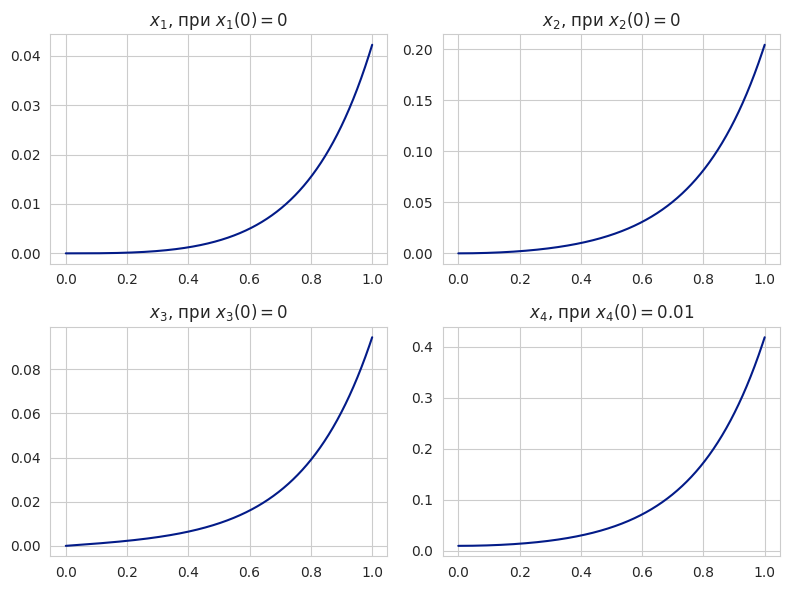

In [46]:
x0 = [0,0,0,0.01]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

plt.tight_layout()

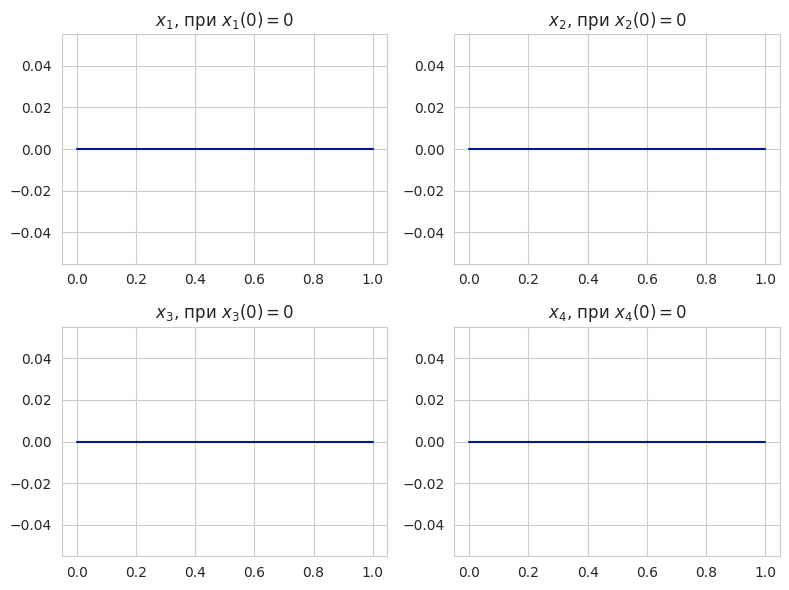

In [47]:
x0 = [0,0,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_lin = ctrl.initial_response(sys_for_an,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_lin.states[i])

plt.tight_layout()

Non-linear

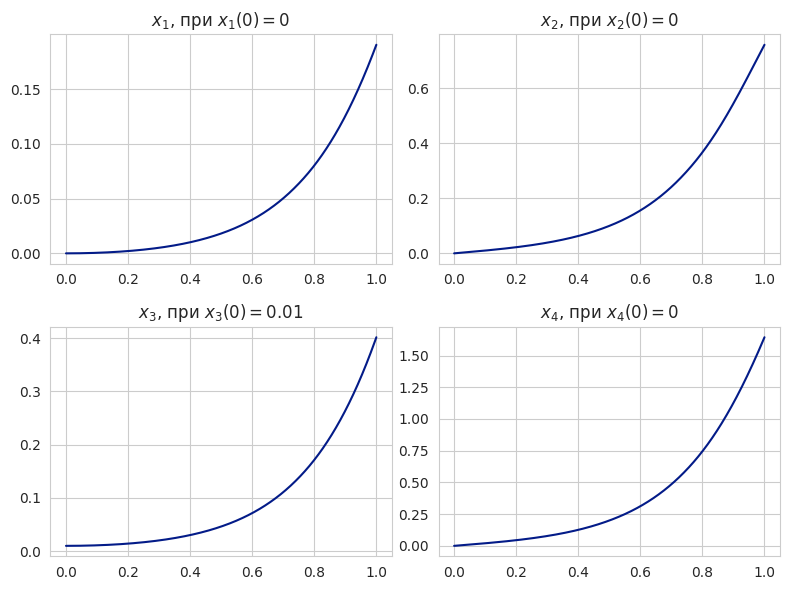

In [48]:
x0 = [0,0,0.01,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

plt.tight_layout()

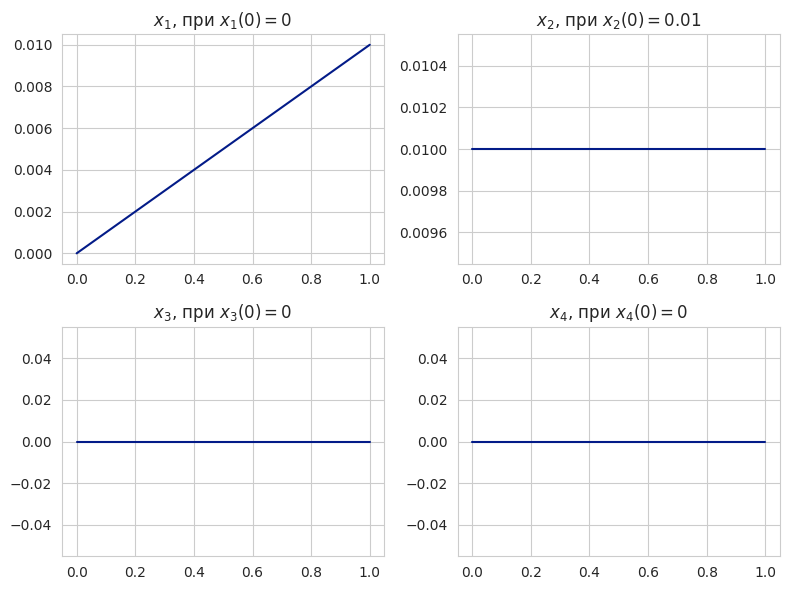

In [49]:
x0 = [0,0.01,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

plt.tight_layout()

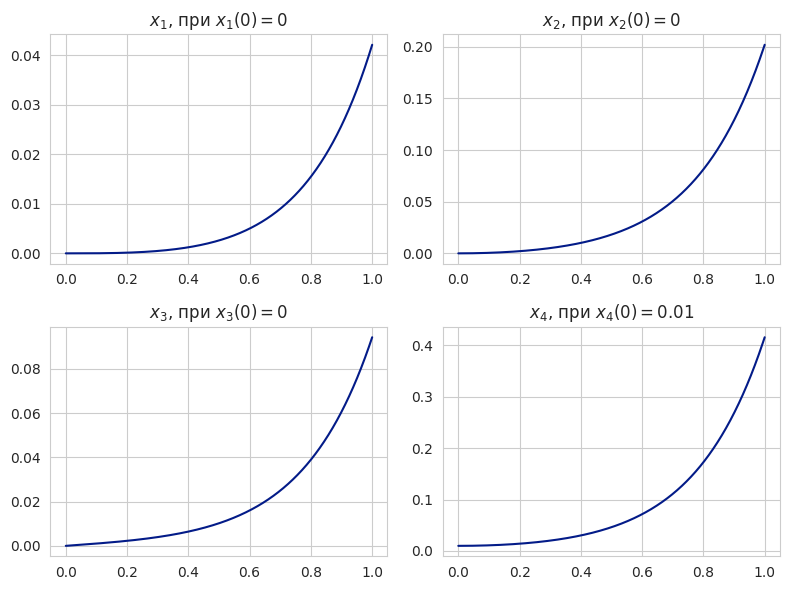

In [50]:
x0 = [0,0,0,0.01]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

plt.tight_layout()

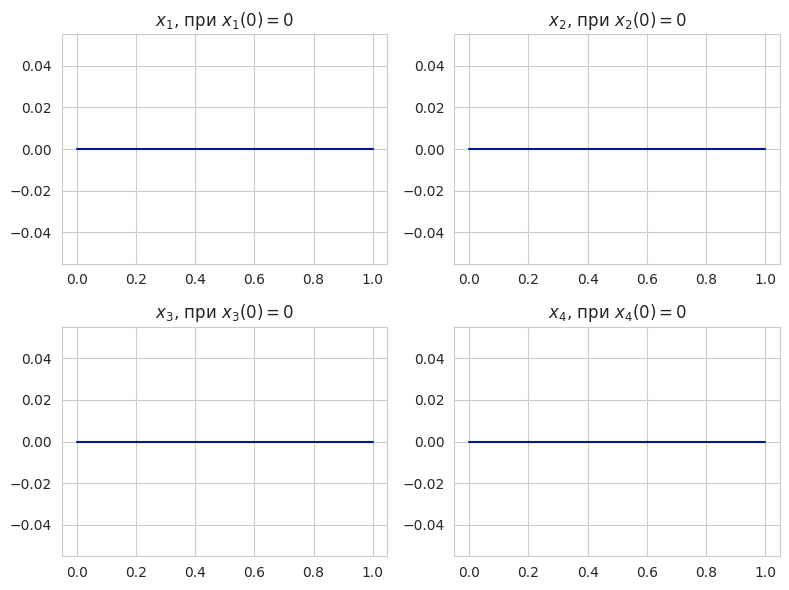

In [51]:
x0 = [0,0,0,0]
time_1 = np.linspace(0,1,int(1/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_1,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_1,out_nonlin.states[i])

plt.tight_layout()

Comparison

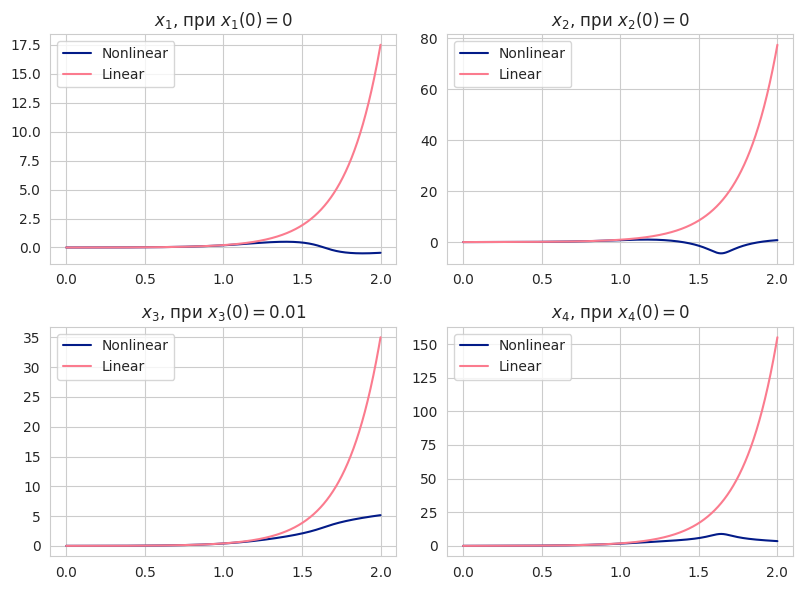

In [52]:
x0 = [0,0,0.01,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()
plt.tight_layout()

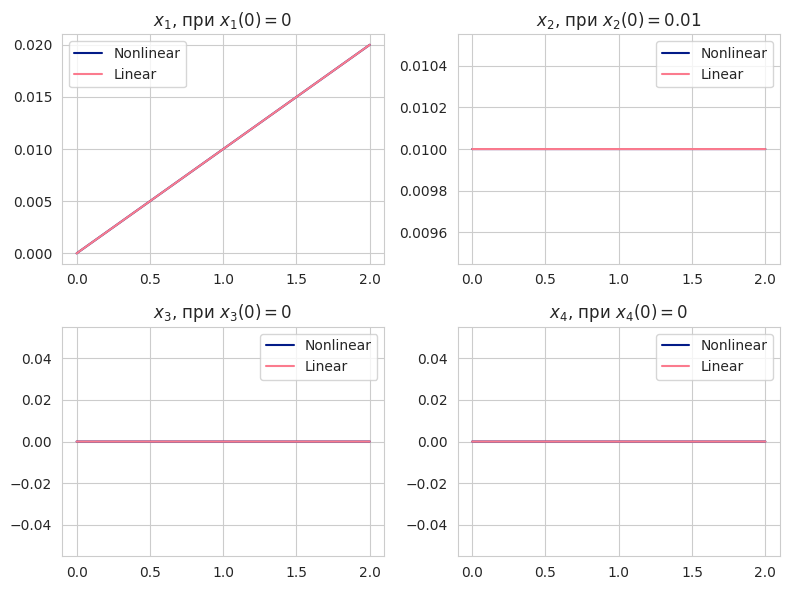

In [53]:
x0 = [0,0.01,0,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()
plt.tight_layout()

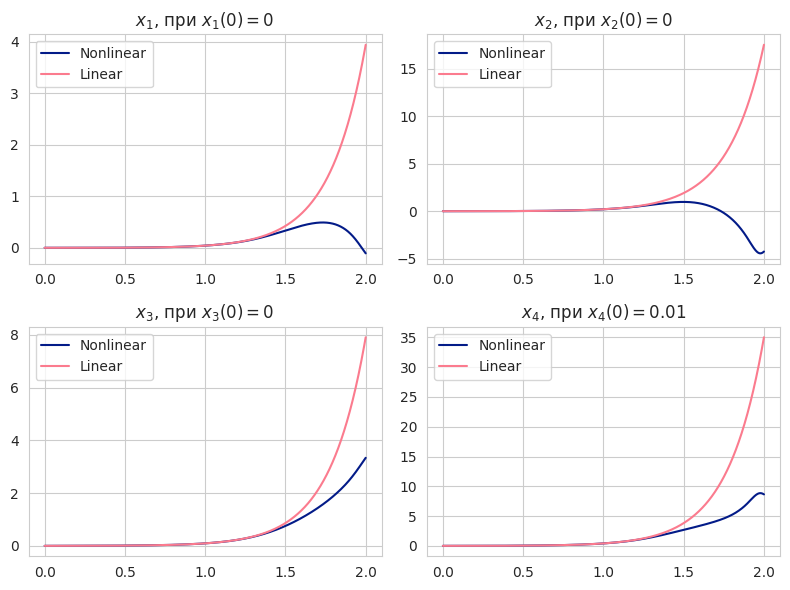

In [54]:
x0 = [0,0,0,0.01]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

plt.tight_layout()

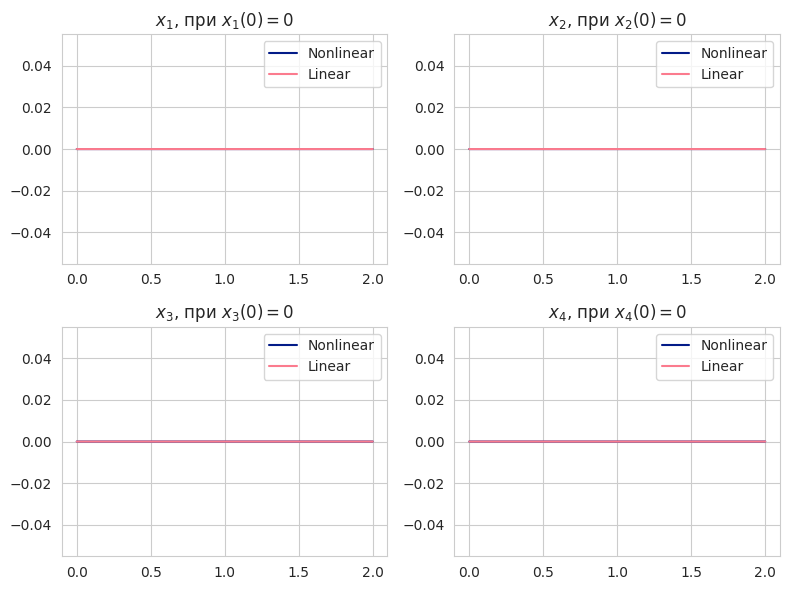

In [55]:
x0 = [0,0,0,0]
time_2 = np.linspace(0,2,int(2/0.001))
out_nonlin = ctrl.input_output_response(non_lin_sys,T=time_2,X0=x0)
out_lin = ctrl.initial_response(sys_for_an,T=time_2,X0=x0)
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i in range(4):
    ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
    ax[i//2, i%2].plot(time_2,out_nonlin.states[i], label="Nonlinear")
    ax[i//2, i%2].plot(time_2,out_lin.states[i], label="Linear")
    ax[i//2, i%2].legend()

plt.tight_layout()

## Modal control

In [56]:
def task3_get_K(A, B, G, Y):
    P= cp.Variable(A.shape)
    objective = cp.Minimize(cp.sum_squares(A @ P - P @ G - B @ Y))
    prob = cp.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(P.value)}')
    K = - Y @ np.linalg.pinv(P.value)
    print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
    return K

def task1_simulate(A, B, K, x0, ts):
    print(f'spec(A + B@K): {np.linalg.eigvals(A + B@K)}')
    ss = ctrl.ss(A + B@K, A*0, A*0, A*0)
    return ctrl.forced_response(ss, X0=x0, T=ts)

In [57]:
G = np.diag([-1, -2, -4, -8])
Y = np.ones((B.shape[1], A.shape[0]))
K = task3_get_K(A, B, G, Y)

Optimization error: 1.3081397664764203e-30, rankP = 4
\[K = \begin{bmatrix}
  6.53 &  12.24 & -96.13 & -27.24
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -8.00 & -4.00 & -2.00 & -1.00
\end{bmatrix}\]


In [58]:
def up_func(t, x, u, params):
    ''' 
    u[0] -- u
    u[1] -- f
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": K})
ss_non_lin.set_inputs(2)

In [59]:
def non_linear_compare_mod_control(ss_lin, ss_non_lin, x0, ts):
    resp = ctrl.initial_response(ss_lin, T=ts, X0=x0)
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    for i in range(4):
        ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
        ax[i//2, i%2].plot(ts, resp.states[i], label='lin') 
        ax[i//2, i%2].plot(ts, resp_non_lin.states[i], label='nonlin') 
        
        ax[i//2, i%2].set_xlabel('t') 
        ax[i//2, i%2].grid(True) 
        ax[i//2, i%2].legend() 
        plt.tight_layout()
        plt.savefig(f'{SAVE_PATH}/task3_1_{"_".join([str(x) for x in x0])}.jpg')

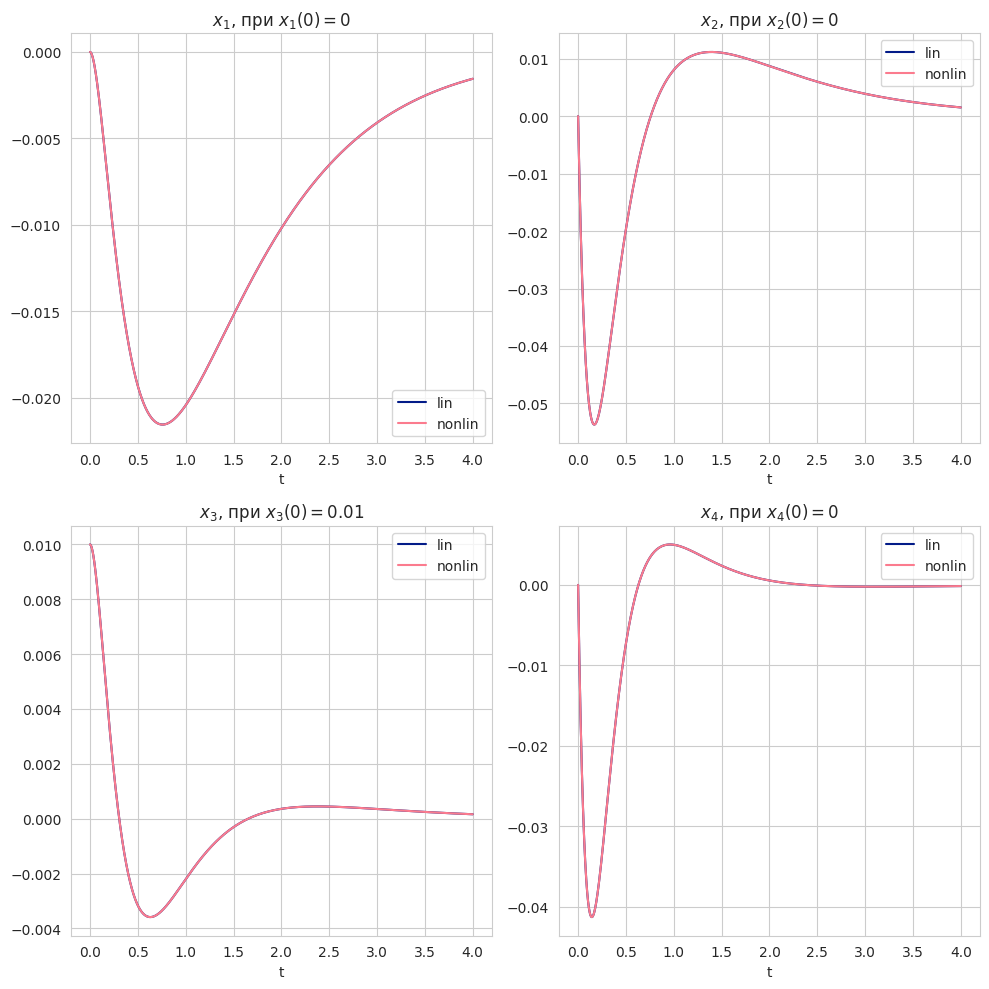

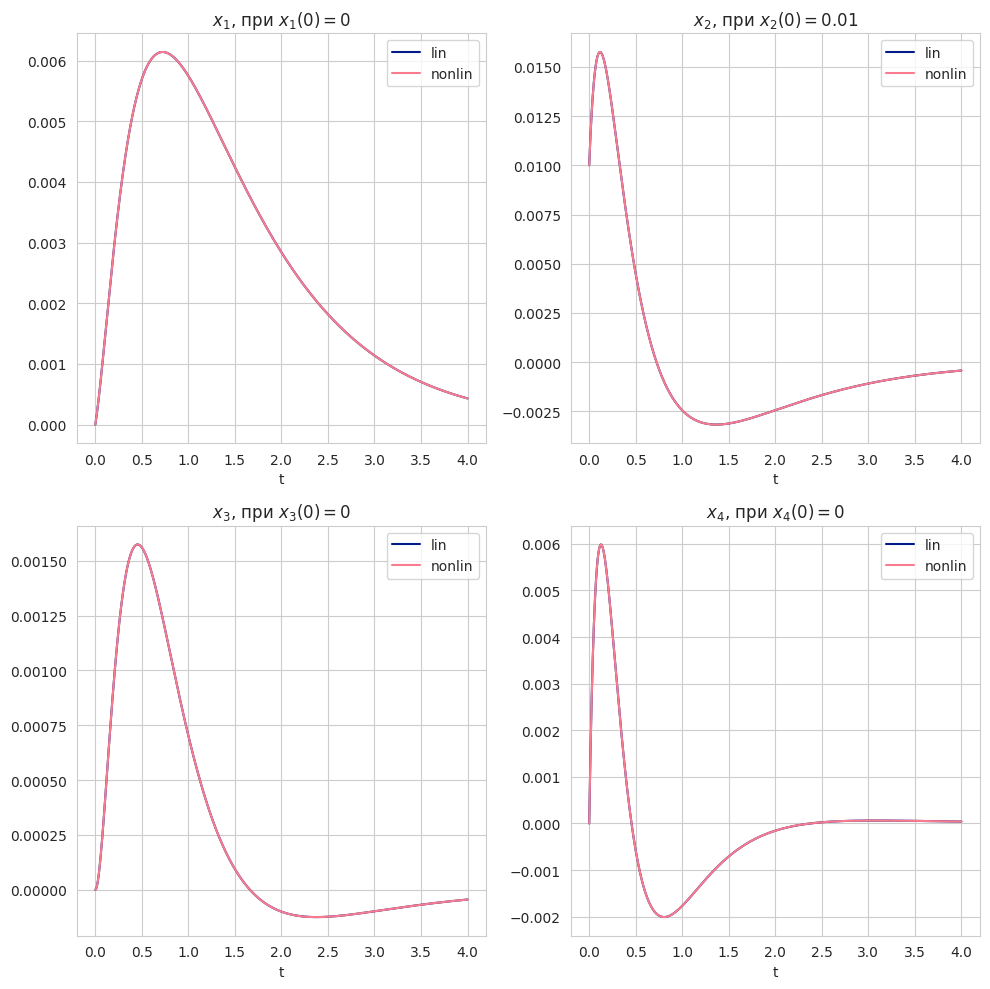

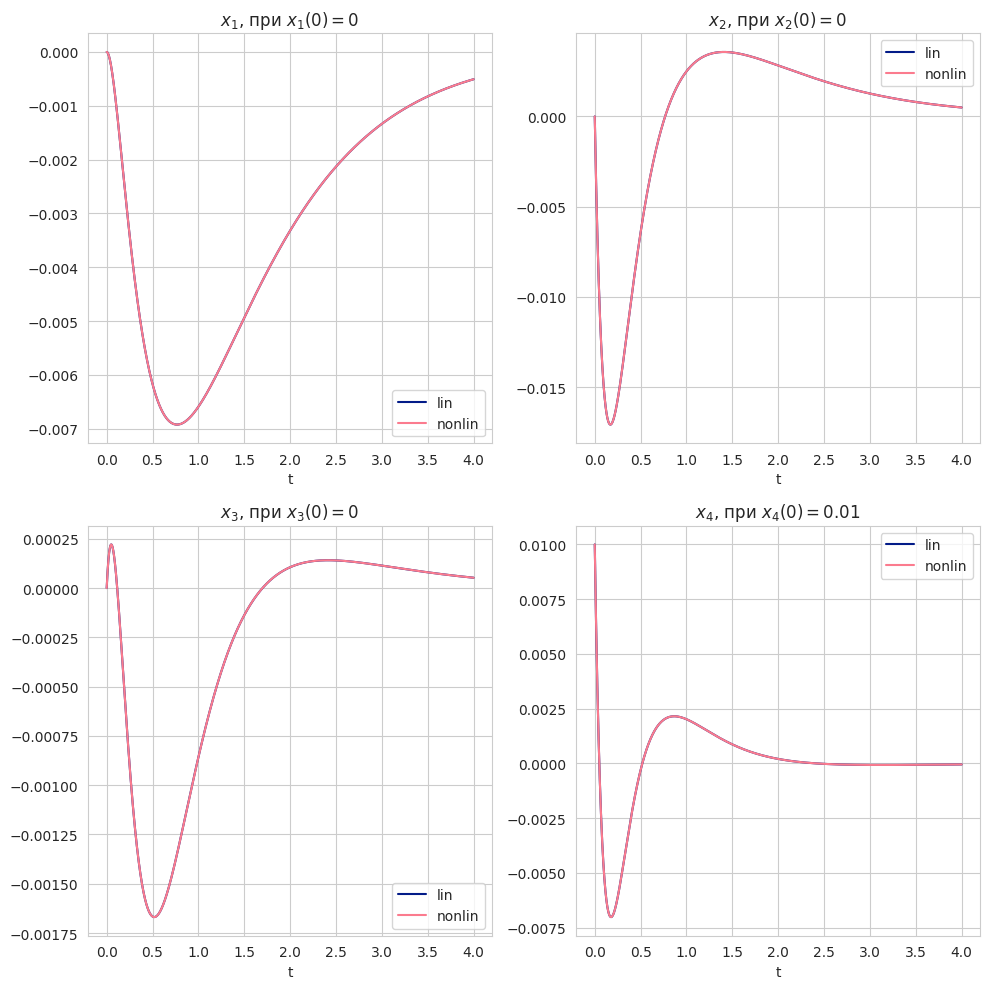

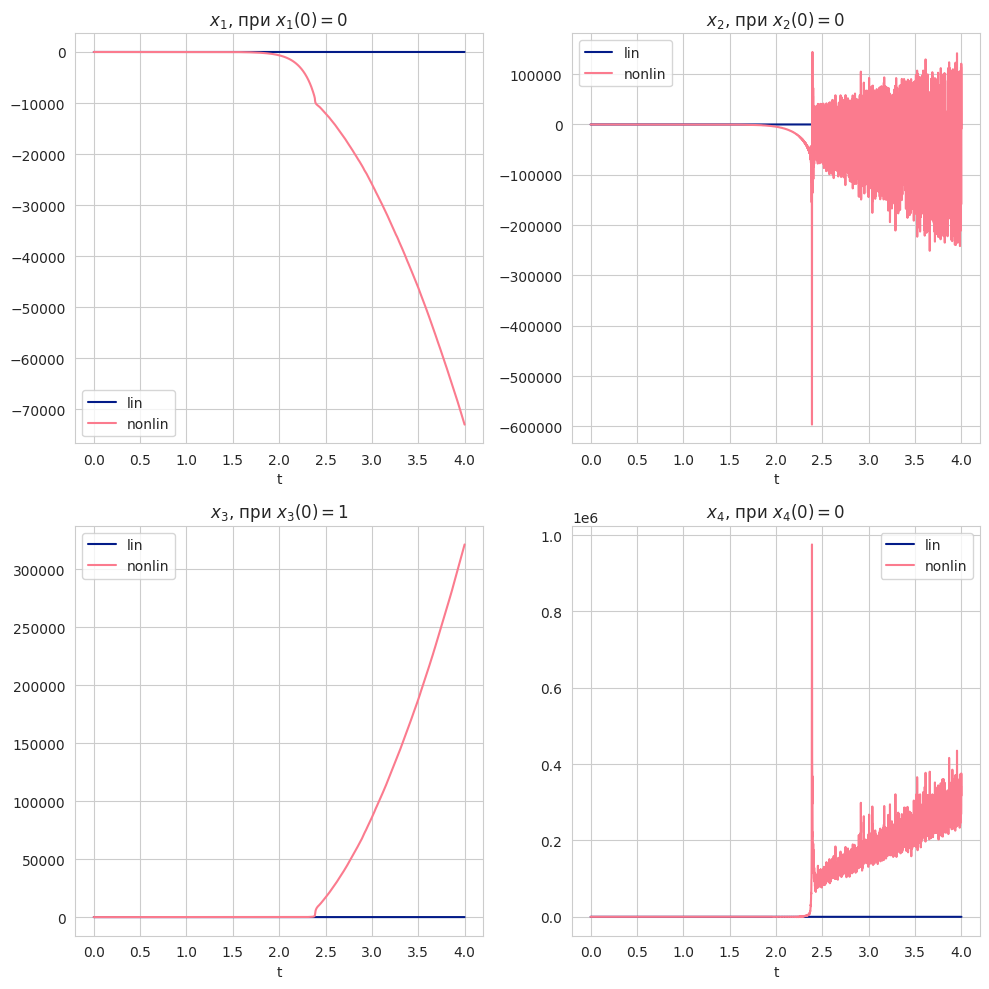

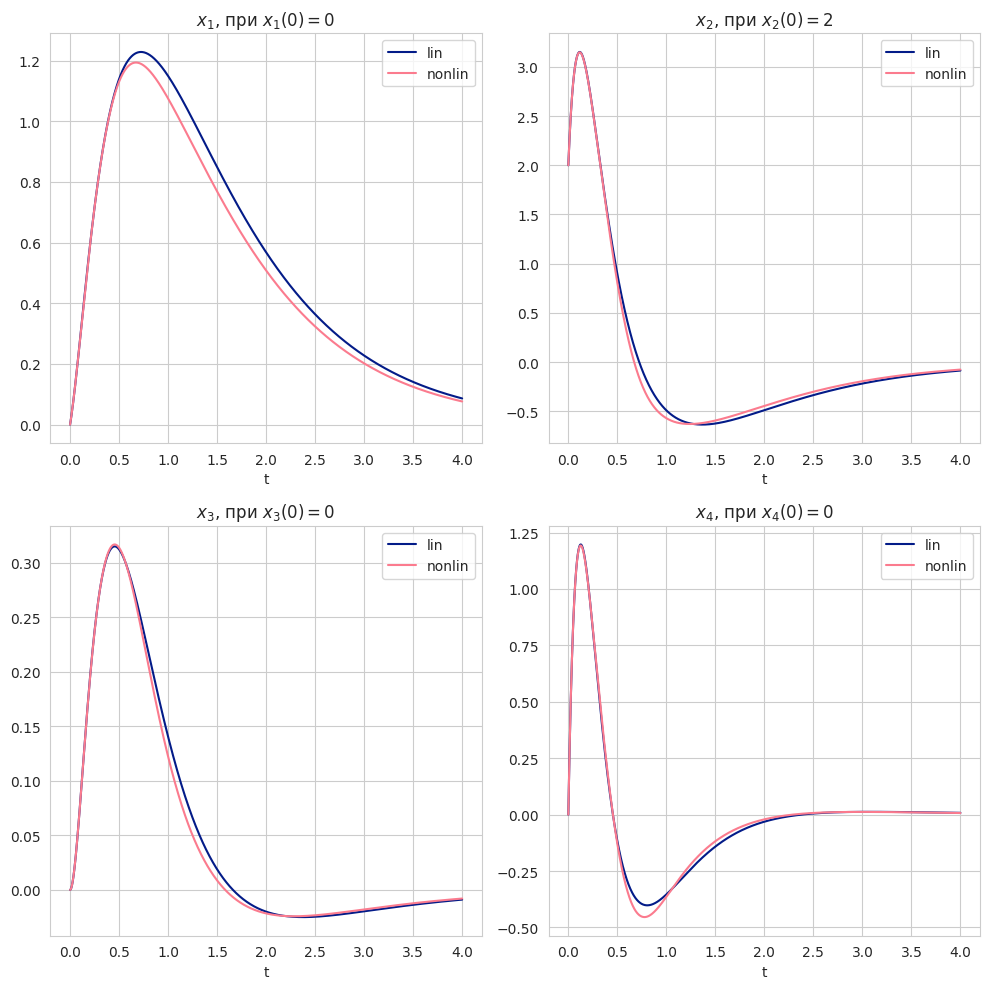

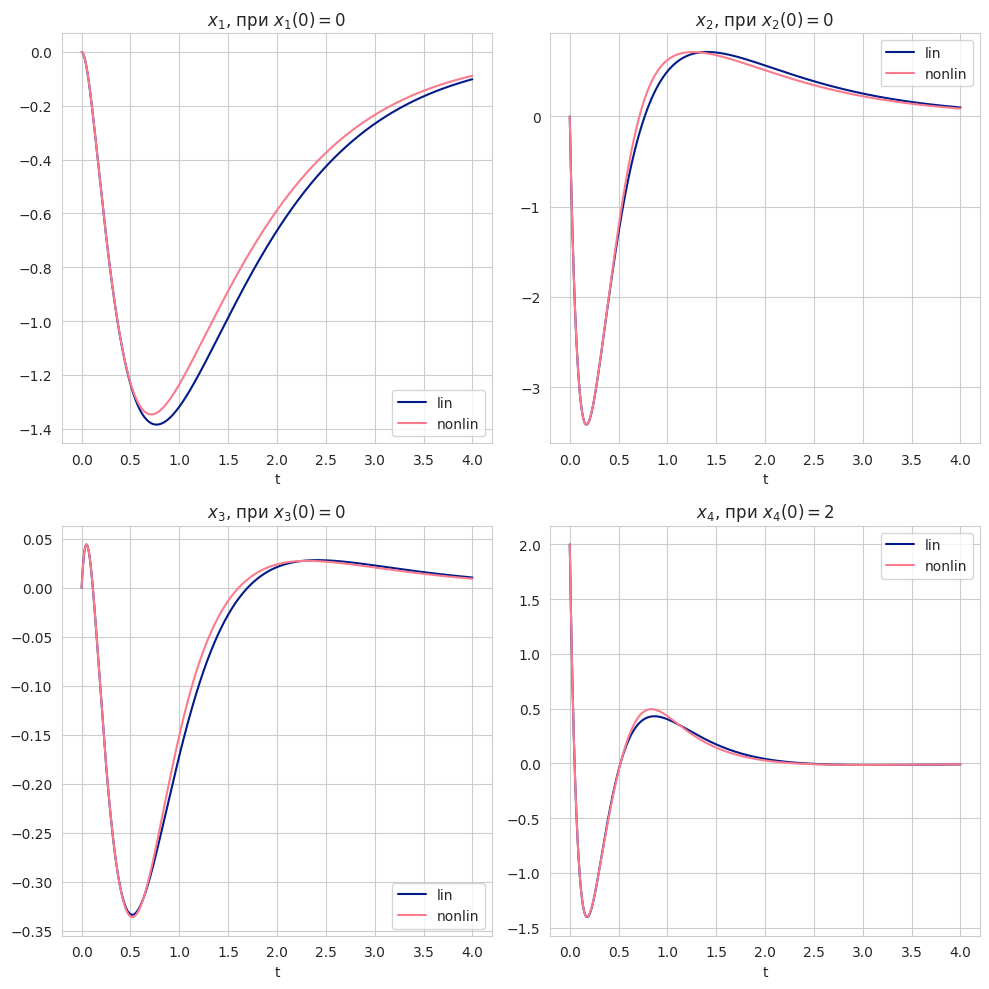

In [60]:
x0s = [
    [0, 0, 0.01, 0], 
    [0, 0.01, 0, 0], 
    [0, 0, 0, 0.01], 
    [0, 0, 1, 0], 
    [0, 2, 0, 0], 
    [0, 0, 0, 2]
]
ts = get_t(4)
ss_mod = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
for x0 in x0s:
    non_linear_compare_mod_control(ss_mod, ss_non_lin, x0, ts)

3.2

In [61]:
def task32_get_K(A, B, G, Y):
    P= cp.Variable(A.shape)
    objective = cp.Minimize(cp.sum_squares(A @ P - P @ G - B @ Y))
    prob = cp.Problem(objective)
    err = prob.solve()
    assert err < 1, 'Not solved for K'
    K = - Y @ np.linalg.pinv(P.value)
    return K
Gs = [np.diag([-1, -2, -4, -8])*2,
      np.diag([-1, -2, -4, -8]), 
      np.diag([-1, -2, -4, -8]) / 10, 
      np.array([[-1, -1, 0, 0], 
                [1, -1, 0, 0], 
                [0, 0, -5, -5], 
                [0, 0, 5, -5]])
    ]

\begin{center}
    \begin{tabular}{ c | c c c }
$\sigma G$ & $\max x$ & $\max \varphi$ & $\max u$ \\
        $\begin{bmatrix}
 -2.00 & -4.00 & -8.00 & -16.00
\end{bmatrix}$ & 1.2 & 6.6 & 202.0 \\
        $\begin{bmatrix}
 -1.00 & -2.00 & -4.00 & -8.00
\end{bmatrix}$ & 1.3 & 2.2 & 48.1 \\
        $\begin{bmatrix}
 -0.10 & -0.20 & -0.40 & -0.80
\end{bmatrix}$ & 100.7 & 16.3 & 141.6 \\
        $\begin{bmatrix}
 -1.00 + 1.00j & -1.00 + -1.00j & -5.00 + 5.00j & -5.00 + -5.00j
\end{bmatrix}$ & 1.2 & 2.7 & 50.9 \\
    \end{tabular}
\end{center}


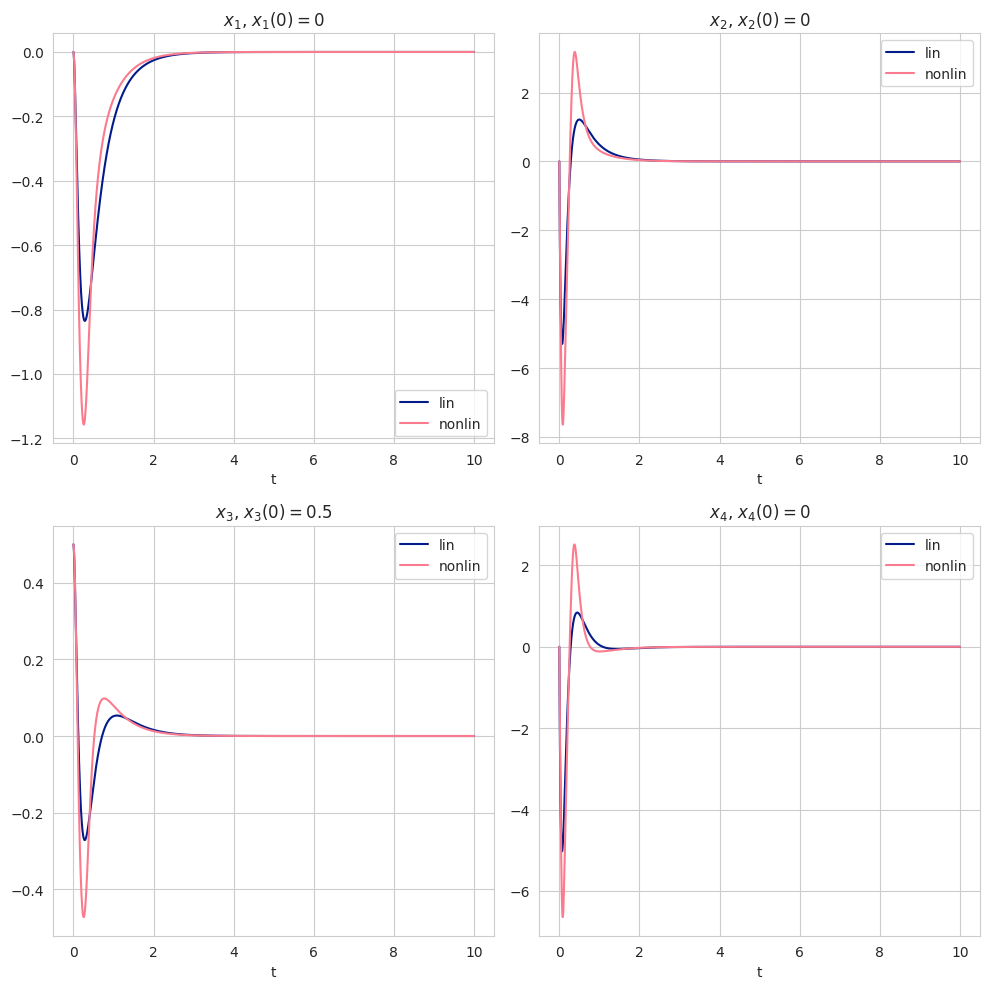

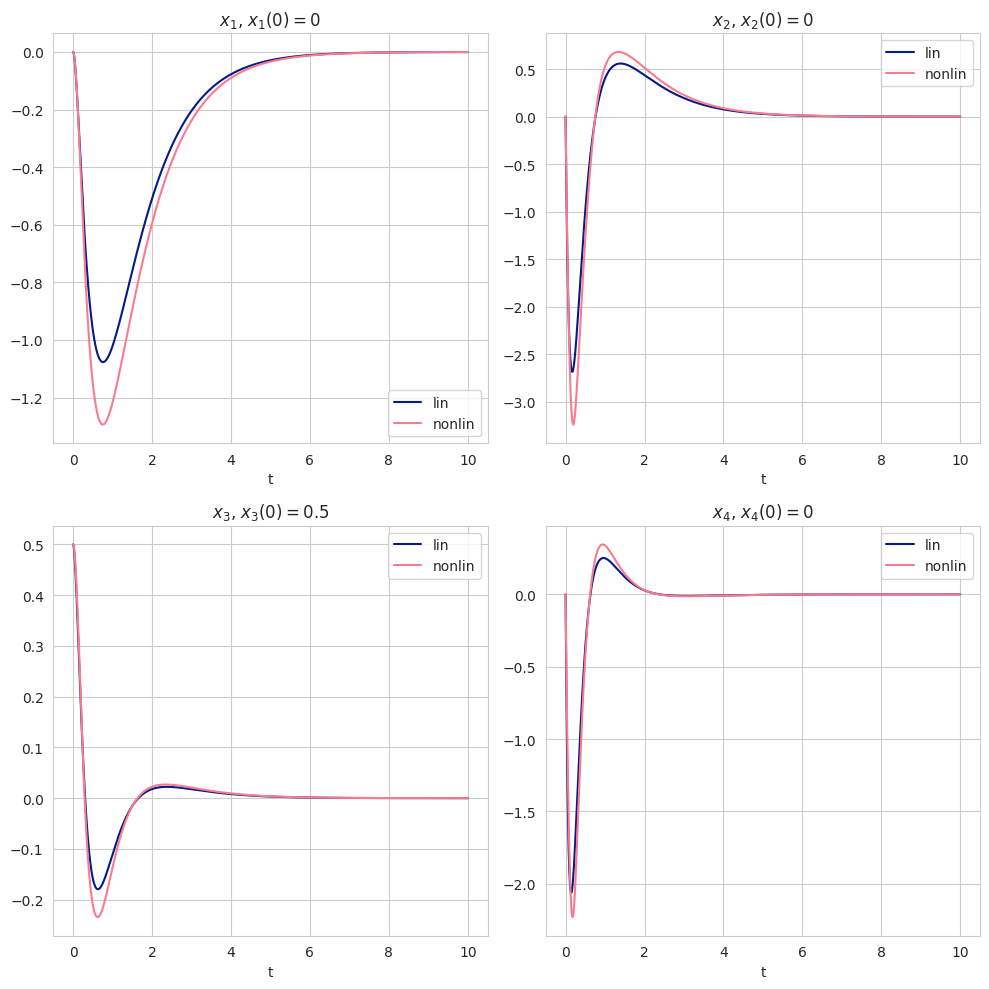

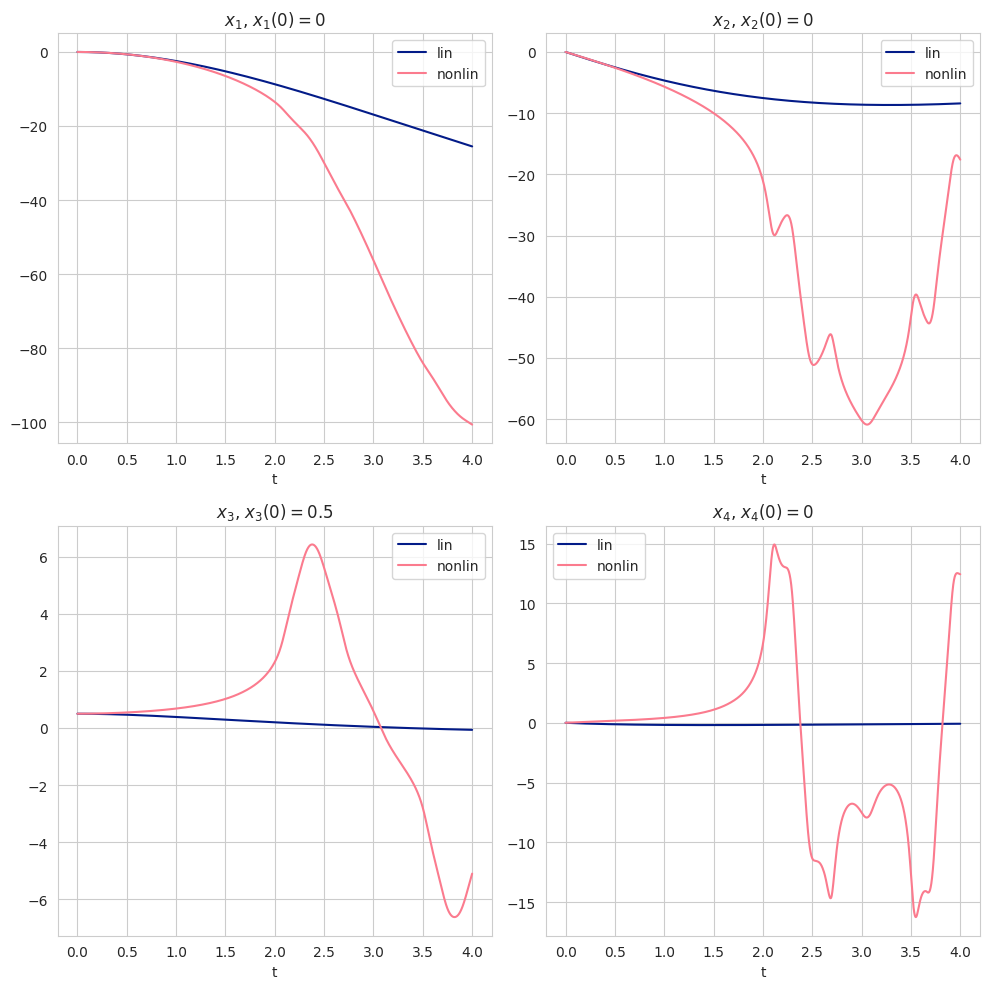

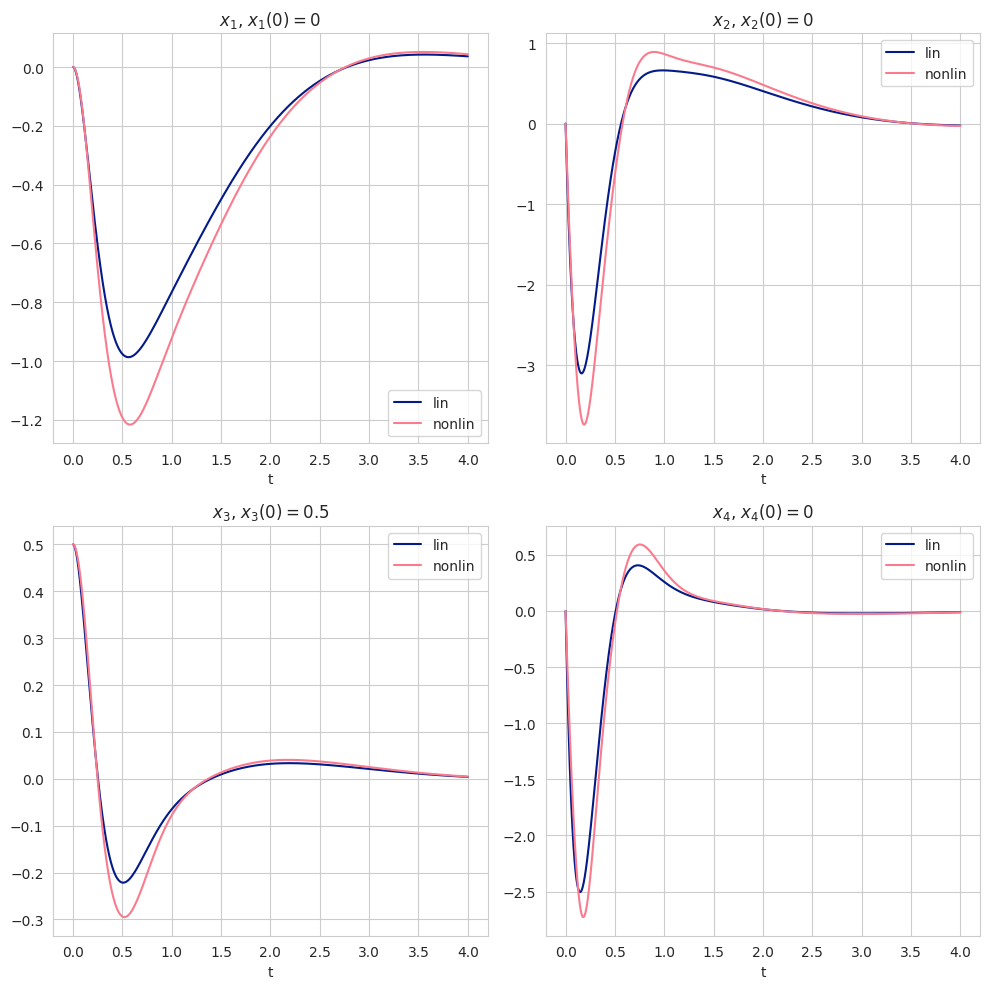

In [62]:
ts = get_t(10)
Y = np.ones((B.shape[1], A.shape[0]))
print('\\begin{center}\n    \\begin{tabular}{ c | c c c }')
print('$\sigma G$ & $\max x$ & $\max \\varphi$ & $\max u$ \\\\')
for i, G in enumerate(Gs):
    if i == 2:
        ts = get_t(4)
    K = task32_get_K(A, B, G, Y)
    x0 = [0, 0, 0.5, 0]
    ss_mod = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
    ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": K})
    ss_non_lin.set_inputs(2)
    resp = ctrl.initial_response(ss_mod, T=ts, X0=x0)
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(4):
        ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
        ax[i//2, i%2].plot(ts, resp.states[i], label='lin') 
        ax[i//2, i%2].plot(ts, resp_non_lin.states[i], label='nonlin') 
        
        ax[i//2, i%2].set_xlabel('t') 
        ax[i//2, i%2].grid(True) 
        ax[i//2, i%2].legend() 
        plt.tight_layout()
        
        plt.savefig(f'{SAVE_PATH}/task3_2_{"_".join([str(x) for x in np.diag(G)])}.jpg')
    print(f'        ${a2l.to_ltx(np.linalg.eigvals(G), print_out=False)}$ & {round(np.abs(resp_non_lin.states[0]).max(), 1)} & {round(np.abs(resp_non_lin.states[3]).max(), 1)} & {round(np.abs(K @ resp_non_lin.states).max(), 1)} \\\\')
print("    \end{tabular}\n\end{center}")

\begin{center}
    \begin{tabular}{ c | c c c }
$\sigma G$ & $\max x$ & $\max \varphi$ & $\max u$ \\
        $\begin{bmatrix}
 -2.00 & -4.00 & -8.00 & -16.00
\end{bmatrix}$ & 1.2 & 6.6 & 202.0 \\
        $\begin{bmatrix}
 -1.00 & -2.00 & -4.00 & -8.00
\end{bmatrix}$ & 1.3 & 2.2 & 48.1 \\
        $\begin{bmatrix}
 -0.10 & -0.20 & -0.40 & -0.80
\end{bmatrix}$ & 100.7 & 16.3 & 141.6 \\
        $\begin{bmatrix}
 -1.00 + 1.00j & -1.00 + -1.00j & -5.00 + 5.00j & -5.00 + -5.00j
\end{bmatrix}$ & 1.2 & 2.7 & 50.9 \\
    \end{tabular}
\end{center}


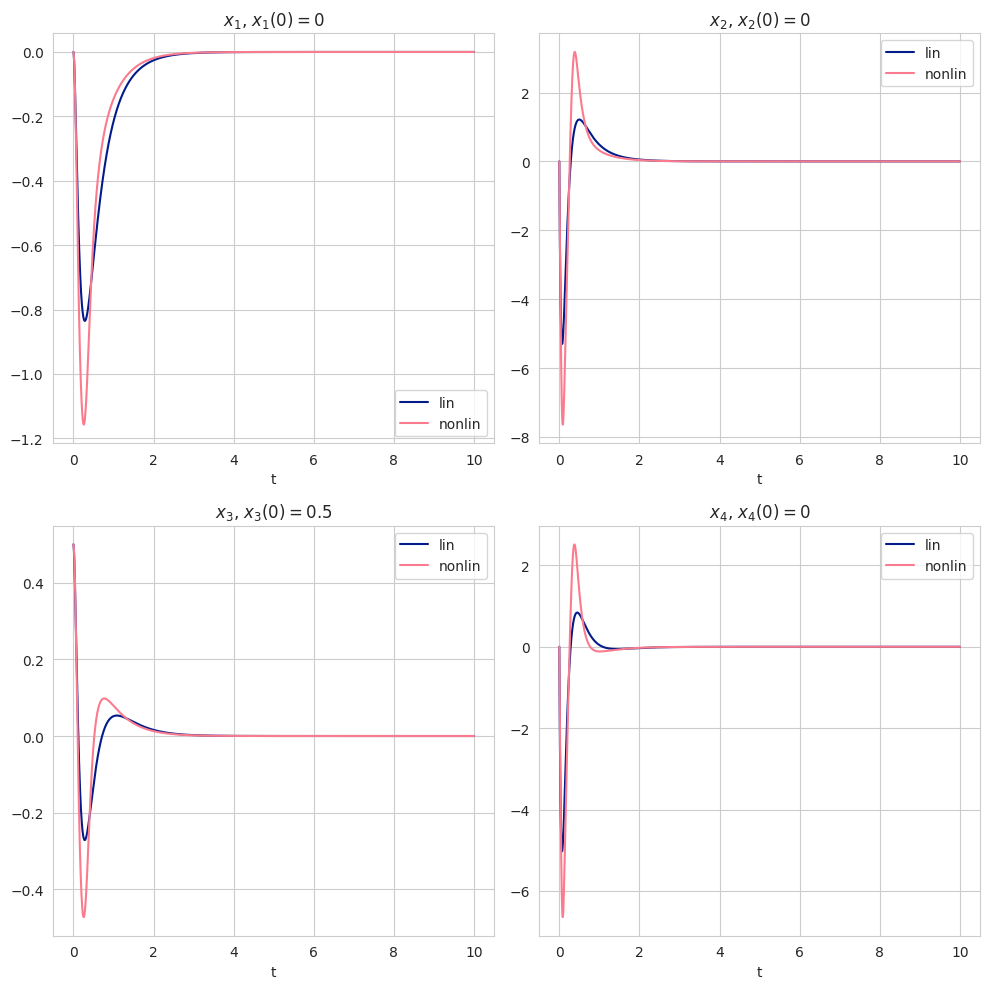

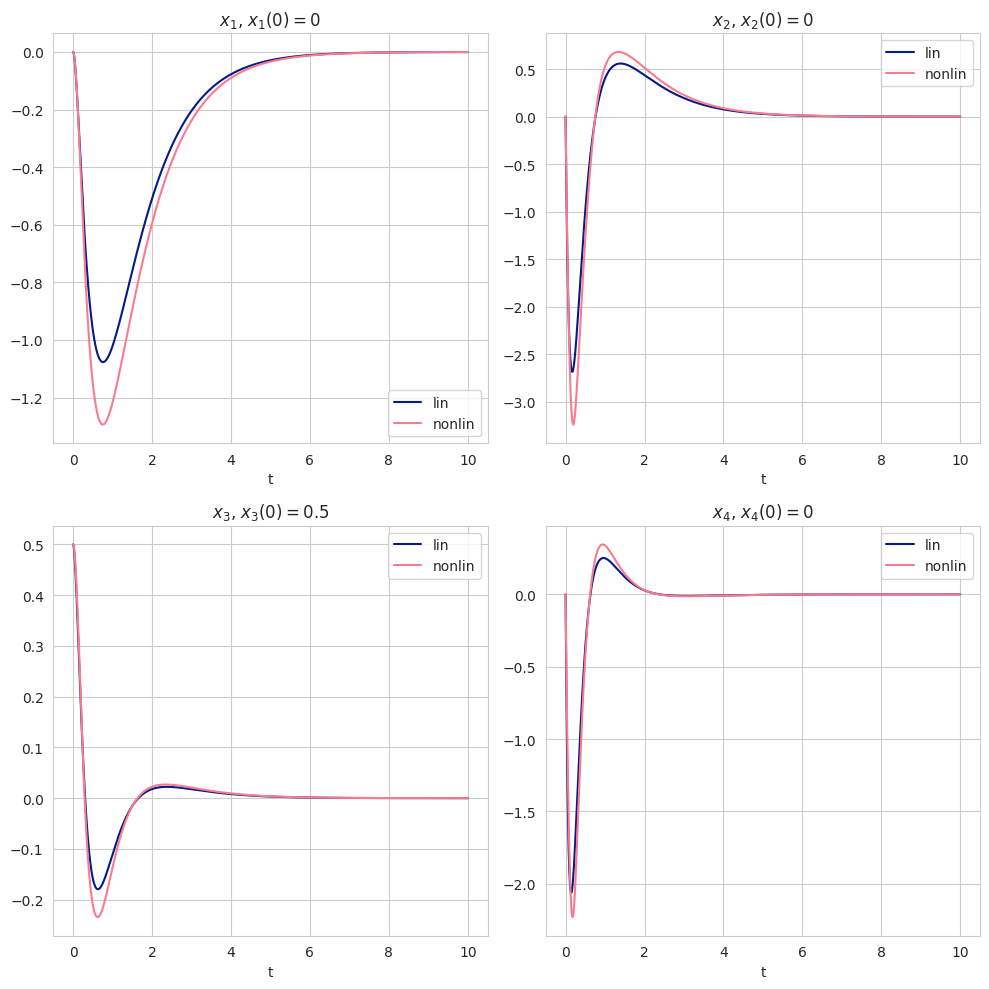

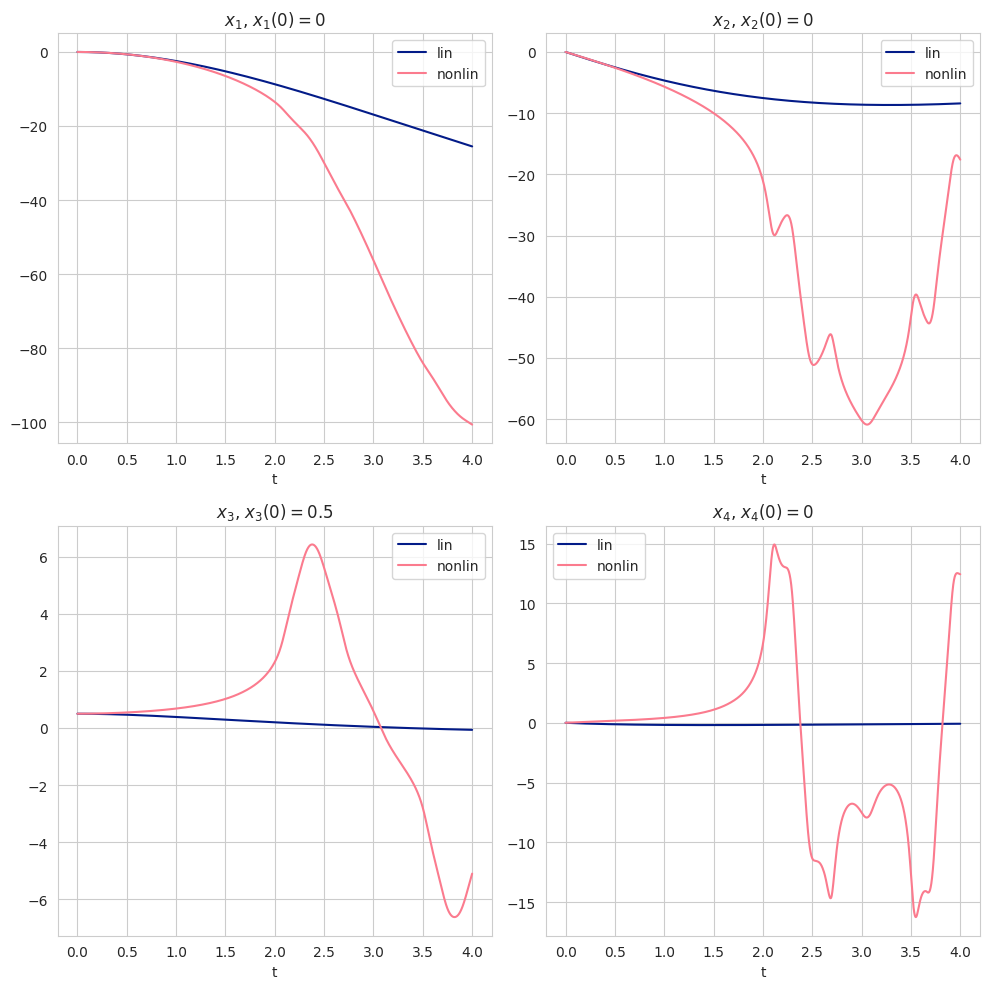

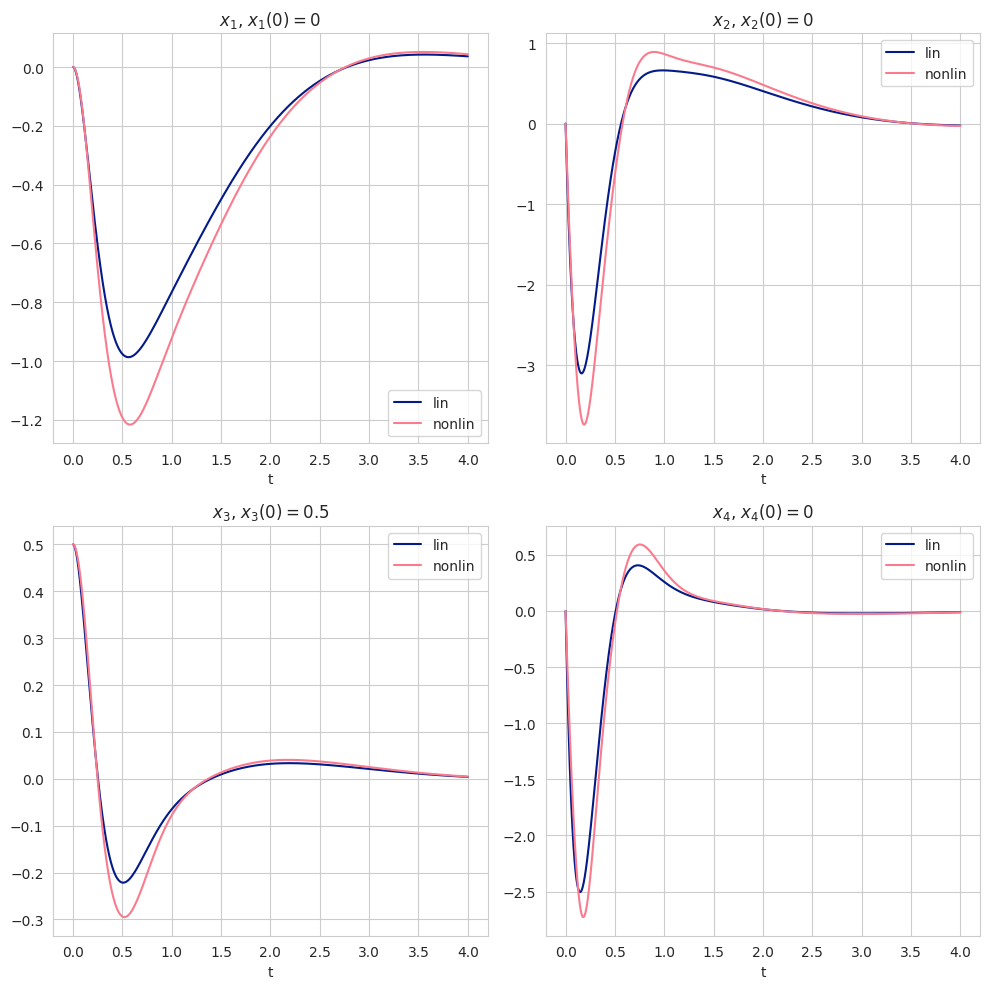

In [63]:
ts = get_t(10)
Y = np.ones((B.shape[1], A.shape[0]))
print('\\begin{center}\n    \\begin{tabular}{ c | c c c }')
print('$\sigma G$ & $\max x$ & $\max \\varphi$ & $\max u$ \\\\')
for i, G in enumerate(Gs):
    if i == 2:
        ts = get_t(4)
    K = task32_get_K(A, B, G, Y)
    x0 = [0, 0, 0.5, 0]
    ss_mod = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
    ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": K})
    ss_non_lin.set_inputs(2)
    resp = ctrl.initial_response(ss_mod, T=ts, X0=x0)
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(4):
        ax[i//2, i%2].set_title(f"$x_{i+1}$, $x_{i+1}(0) = {x0[i]}$")
        ax[i//2, i%2].plot(ts, resp.states[i], label='lin') 
        ax[i//2, i%2].plot(ts, resp_non_lin.states[i], label='nonlin') 
        
        ax[i//2, i%2].set_xlabel('t') 
        ax[i//2, i%2].grid(True) 
        ax[i//2, i%2].legend() 
        plt.tight_layout()
        
        plt.savefig(f'{SAVE_PATH}/task3_2_{"_".join([str(x) for x in np.diag(G)])}.jpg')
    print(f'        ${a2l.to_ltx(np.linalg.eigvals(G), print_out=False)}$ & {round(np.abs(resp_non_lin.states[0]).max(), 1)} & {round(np.abs(resp_non_lin.states[3]).max(), 1)} & {round(np.abs(K @ resp_non_lin.states).max(), 1)} \\\\')
print("    \end{tabular}\n\end{center}")

3.3

In [64]:
def task3_get_L(A, C, G, Y):
    Q = cp.Variable(A.shape)
    objective = cp.Minimize(cp.sum_squares(G @ Q - Q @ A - Y @ C))
    prob = cp.Problem(objective)
    assert prob.solve() < 1, 'Not solved'
    return np.linalg.pinv(Q.value) @ Y

def up_func_L(t, x, u, params):
    ''' 
    u[0] -- y_0
    u[1] -- y_1
    '''
    L = params.get('L', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ]) + L @ (C@x - u)

In [80]:
Gs = [np.diag([-1, -2, -4, -8])*2,
      np.diag([-1, -2, -4, -8]), 
      np.diag([-1, -2, -4, -8]) / 10, 
      np.array([[-1, -1, 0, 0], 
                [1, -1, 0, 0], 
                [0, 0, -5, -5], 
                [0, 0, 5, -5]])
    ]

In [81]:
ts = get_t(10)
Y = np.ones((B.shape[1], A.shape[0]))
G = Gs[0]
K = task32_get_K(A, B, G, Y)
ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": K})
ss_non_lin.set_inputs(2)

new_g = Gs[0]
new_y = np.ones((A.shape[0], C.shape[0]))
L = task3_get_L(A, C, new_g, new_y).astype(np.float64)
print(f'\[L = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[\Gamma = {a2l.to_ltx(new_g, print_out=False)}\]')
print(f'\[Y = {a2l.to_ltx(new_y, print_out=False)}\]')

ss_non_lin_obs = ctrl.NonlinearIOSystem(up_func_L, params={"L": L, 'C': C})
ss_non_lin_obs.set_inputs(2)

\[L = \begin{bmatrix}
  104.49 &  97.96 & -404.09 & -127.96
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -2.00 &  0.00 &  0.00 &  0.00\\
  0.00 & -4.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -8.00 &  0.00\\
  0.00 &  0.00 &  0.00 & -16.00
\end{bmatrix}\]
\[Y = \begin{bmatrix}
  1.00 &  1.00\\
  1.00 &  1.00\\
  1.00 &  1.00\\
  1.00 &  1.00
\end{bmatrix}\]


[0.1, 0, 0.1, 0]
0
1
2
3


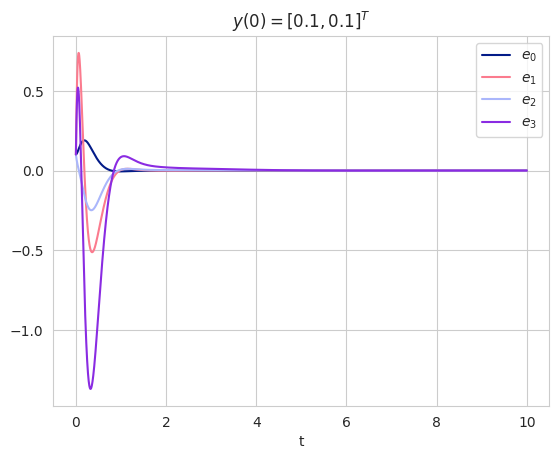

[0, 0, 0.4, 0]
0
1
2
3


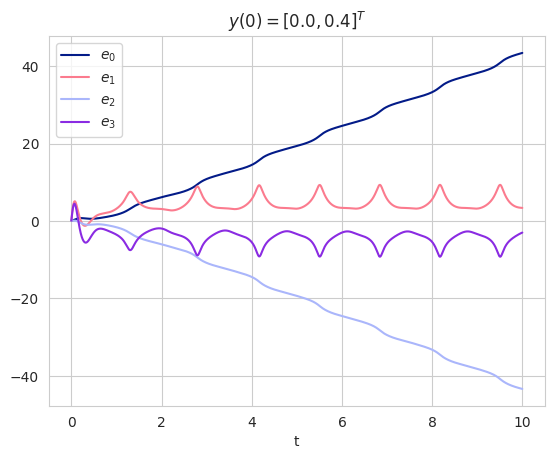

[0.4, 0, 0, 0]
0
1
2
3


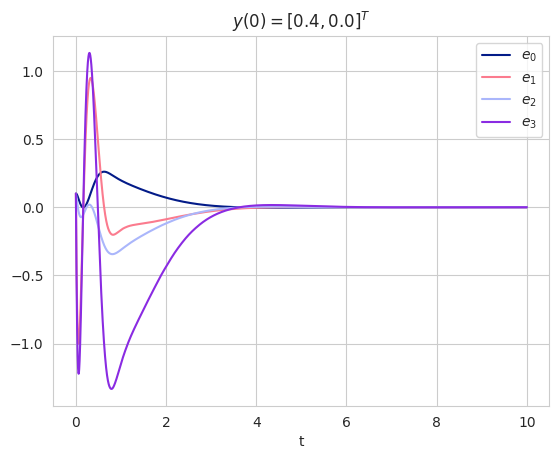

In [113]:
solve_ivp_kwargs = {
    'method': 'Radau',  # You can try 'RK23', 'DOP853', 'LSODA', etc.
}

x0s = [[0.1, 0, 0.1, 0], [0, 0, 0.4, 0], [0.4, 0, 0, 0]]
for x0 in x0s:
    print(x0)
    x0 = np.array(x0)
    resp_non_lin = ctrl.input_output_response(
        ss_non_lin, 
        T=ts, 
        X0=x0, 
        U=np.zeros((2, len(ts))),
        solve_ivp_kwargs=solve_ivp_kwargs
    )
    resp_non_lin_obs = ctrl.input_output_response(ss_non_lin_obs, T=ts, X0=x0 + 0.1, U=C @ resp_non_lin.states)
    err = resp_non_lin_obs.states - resp_non_lin.states
    for i in range(4):
        print(i)
        plt.plot(ts, err[i], label=f'$e_{i}$') 
        plt.xlabel('t') 
        plt.grid() 
        plt.legend() 
        plt.title(f'$y(0) = [{x0[0]}, {x0[2]}]^T$')
        plt.savefig(f'{SAVE_PATH}/task3_3_{x0[0]}_{x0[2]}.jpg')
    plt.show()
    plt.close()

3.4

\[L = \begin{bmatrix}
  104.49 &  97.96 & -404.09 & -127.96
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -2.00 &  0.00 &  0.00 &  0.00\\
  0.00 & -4.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -8.00 &  0.00\\
  0.00 &  0.00 &  0.00 & -16.00
\end{bmatrix}\]


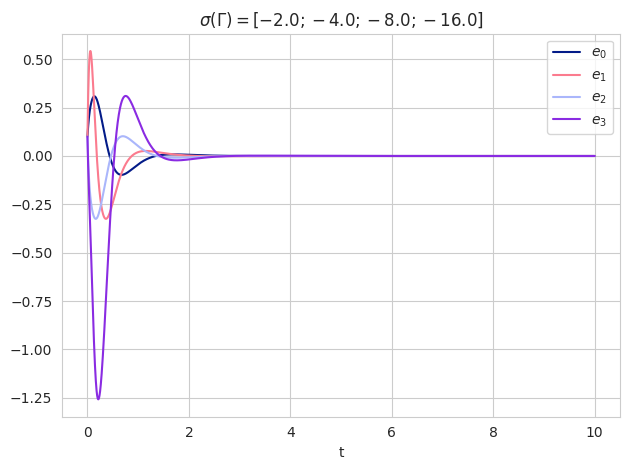

\[L = \begin{bmatrix}
  104.49 &  97.96 & -404.09 & -127.96
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -1.00 &  0.00 &  0.00 &  0.00\\
  0.00 & -2.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -4.00 &  0.00\\
  0.00 &  0.00 &  0.00 & -8.00
\end{bmatrix}\]


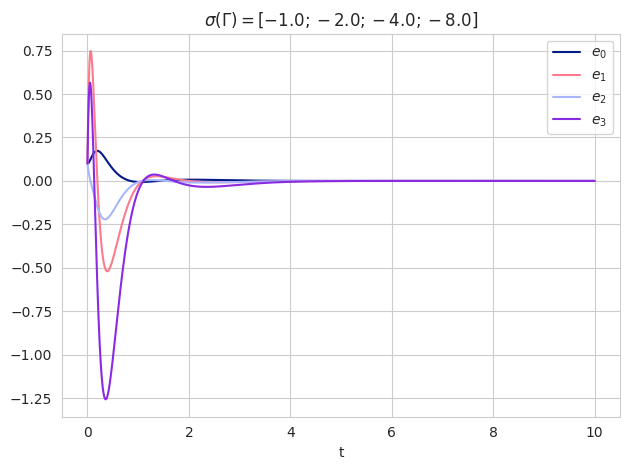

\[L = \begin{bmatrix}
  104.49 &  97.96 & -404.09 & -127.96
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -0.10 &  0.00 &  0.00 &  0.00\\
  0.00 & -0.20 &  0.00 &  0.00\\
  0.00 &  0.00 & -0.40 &  0.00\\
  0.00 &  0.00 &  0.00 & -0.80
\end{bmatrix}\]


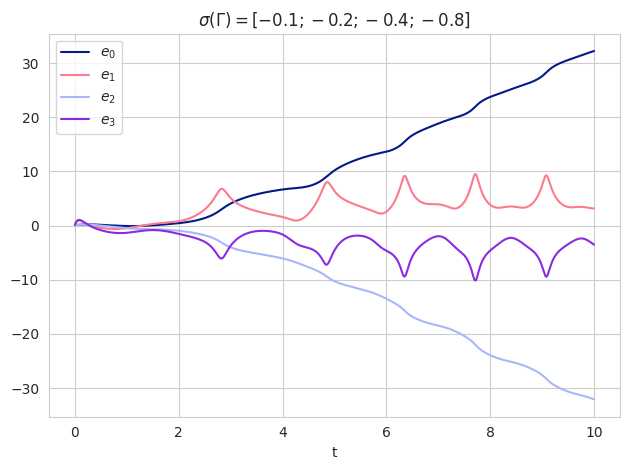

\[L = \begin{bmatrix}
  104.49 &  97.96 & -404.09 & -127.96
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -1.00 & -1.00 &  0.00 &  0.00\\
  1.00 & -1.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -5.00 & -5.00\\
  0.00 &  0.00 &  5.00 & -5.00
\end{bmatrix}\]


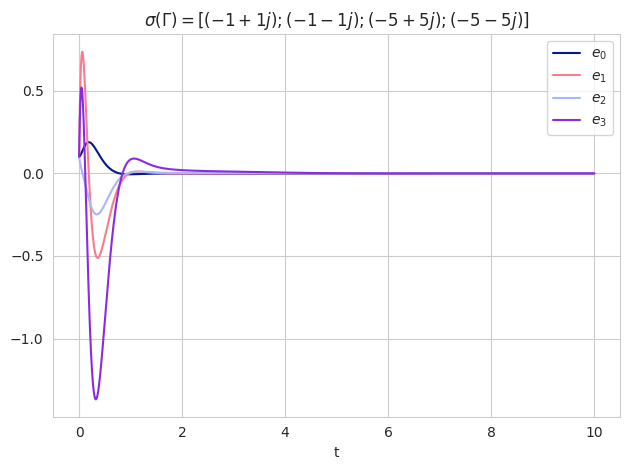

In [114]:
x0 = np.array(x0s[0])
resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
for new_g in Gs:
    L = task3_get_L(A, C, new_g, new_y).astype(np.float64)
    print(f'\[L = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[\Gamma = {a2l.to_ltx(new_g, print_out=False)}\]')

    ss_non_lin_obs = ctrl.NonlinearIOSystem(up_func_L, params={"L": L, 'C': C})
    ss_non_lin_obs.set_inputs(2)
    resp_non_lin_obs = ctrl.input_output_response(ss_non_lin_obs, T=ts, X0=x0 + 0.1, U=C @ resp_non_lin.states)
    err = resp_non_lin_obs.states - resp_non_lin.states
    for i in range(4):
        plt.plot(ts, err[i], label=f'$e_{i}$') 
        plt.xlabel('t') 
        plt.grid() 
        plt.legend() 
        plt.title(f'$\sigma(\Gamma) = [{"; ".join([str(np.round(x, 1)) for x in np.linalg.eigvals(new_g)])}]$')
        plt.savefig(f'{SAVE_PATH}/task3_4_{"_".join([str(x) for x in np.linalg.eigvals(new_g)])}.jpg')
    plt.tight_layout()
    plt.show()
    plt.close()
    

3.5

In [115]:
def up_func_K_L(t, x, u, params):
    ''' 
    x[:4] --  x
    x[4:] --  \hat{x}
    u -- trash
    '''
    L = params.get('L', np.zeros((1, 4)))
    K = params.get('K', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    u[0] = (K @ x[4:]).reshape(-1)[0]
    
    dxh =  np.array([
        x[4 + 1],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*l*np.sin(x[4 + 2])*x[4 + 3]**2 + m*g*np.cos(x[4 + 2])*np.sin(x[4 + 2]) + u[0] + u[1]*np.cos(x[4 + 2])/l),
        x[4 + 3],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*np.cos(x[4 + 2])*np.sin(x[4 + 2])*x[4 + 3]**2 + (M+m)*g*np.sin(x[4 + 2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[4 + 2])/l)
    ]) + L @ (C@x[4:] - C@x[:4])
    
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
    return np.hstack((dx, dxh))

In [116]:
new_y = np.ones((A.shape[0], C.shape[0]))
L = task3_get_L(A, C, Gs[0], new_y).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task32_get_K(A, B, Gs[0], Y)
x0 = np.array(x0s[0])
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[\Gamma = {a2l.to_ltx(new_g, print_out=False)}\]')

\[L = \begin{bmatrix}
  22.65 &  22.65\\
 -65.04 & -65.04\\
 -52.65 & -52.65\\
 -234.56 & -234.56
\end{bmatrix}\]
\[K = \begin{bmatrix}
  104.49 &  97.96 & -404.09 & -127.96
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -1.00 & -1.00 &  0.00 &  0.00\\
  1.00 & -1.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -5.00 & -5.00\\
  0.00 &  0.00 &  5.00 & -5.00
\end{bmatrix}\]


In [133]:
def nonlin_modal_full(x0, ts = get_t(10)):
    ss_non_lin = ctrl.NonlinearIOSystem(up_func_K_L, params={"K": K, "L": L, 'C': C})
    ss_non_lin.set_inputs(2)
    resp_non_lin_by_output = ctrl.input_output_response(
        ss_non_lin, T=ts, X0=np.hstack((x0, x0 + 0.1)), 
        U=C @ resp_non_lin.states[:,:len(ts)],
        solve_ivp_kwargs=solve_ivp_kwargs
    )
    for i in range(4):
        plt.plot(ts, resp_non_lin_by_output.states[i], label=f'$x_{i}$') 
        plt.xlabel('t') 
        plt.legend() 
        plt.savefig(f'{SAVE_PATH}/task3_5_{" ".join([str(x) for x in np.linalg.eigvals(A+B@K)])}.jpg')

\[L = \begin{bmatrix}
  22.65 &  22.65\\
 -65.04 & -65.04\\
 -52.65 & -52.65\\
 -234.56 & -234.56
\end{bmatrix}\]
\[K = \begin{bmatrix}
  104.49 &  97.96 & -404.09 & -127.96
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -2.00 &  0.00 &  0.00 &  0.00\\
  0.00 & -4.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -8.00 &  0.00\\
  0.00 &  0.00 &  0.00 & -16.00
\end{bmatrix}\]


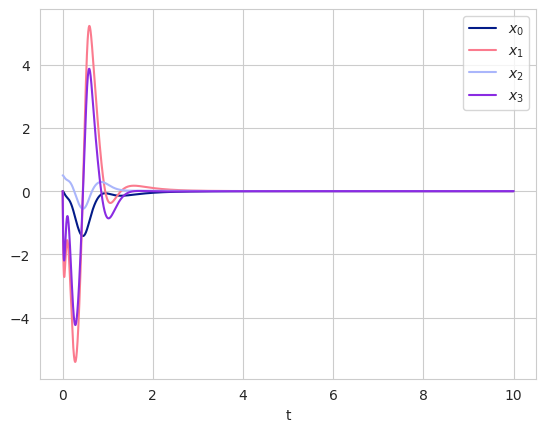

In [140]:
new_y = np.ones((A.shape[0], C.shape[0]))
new_g = Gs[0]

L = task3_get_L(A, C, new_g, new_y).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task32_get_K(A, B, new_g, Y)
x0 = np.array(x0s[0])
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[\Gamma = {a2l.to_ltx(new_g, print_out=False)}\]')
nonlin_modal_full(np.array([0, 0, 0.5, 0]))

\[L = \begin{bmatrix}
 -0.92 & -0.92\\
 -27.69 & -27.69\\
 -14.08 & -14.08\\
 -61.91 & -61.91
\end{bmatrix}\]
\[K = \begin{bmatrix}
  6.53 &  12.24 & -96.13 & -27.24
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -1.00 &  0.00 &  0.00 &  0.00\\
  0.00 & -2.00 &  0.00 &  0.00\\
  0.00 &  0.00 & -4.00 &  0.00\\
  0.00 &  0.00 &  0.00 & -8.00
\end{bmatrix}\]


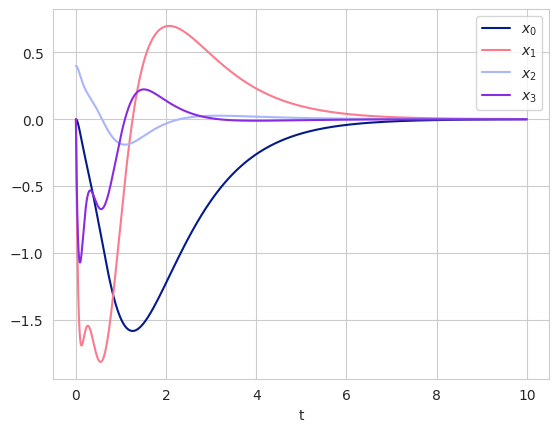

In [138]:
new_y = np.ones((A.shape[0], C.shape[0]))
new_g = Gs[1]
L = task3_get_L(A, C, Gs[1], new_y).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task32_get_K(A, B, Gs[1], Y)
x0 = np.array(x0s[0])
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[\Gamma = {a2l.to_ltx(new_g, print_out=False)}\]')
nonlin_modal_full(np.array(x0s[1]))

\[L = \begin{bmatrix}
 -0.50 & -0.50\\
 -6.77 & -6.77\\
 -1.00 & -1.00\\
 -13.53 & -13.53
\end{bmatrix}\]
\[K = \begin{bmatrix}
  0.00 &  0.01 & -20.30 & -1.51
\end{bmatrix}\]
\[\Gamma = \begin{bmatrix}
 -0.10 &  0.00 &  0.00 &  0.00\\
  0.00 & -0.20 &  0.00 &  0.00\\
  0.00 &  0.00 & -0.40 &  0.00\\
  0.00 &  0.00 &  0.00 & -0.80
\end{bmatrix}\]


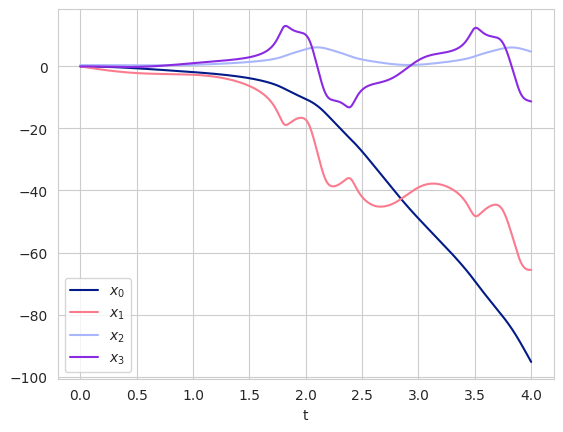

In [137]:
new_y = np.ones((A.shape[0], C.shape[0]))
new_g = Gs[2]
L = task3_get_L(A, C, new_g, new_y).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task32_get_K(A, B, new_g, Y)
x0 = np.array(x0s[0])
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[\Gamma = {a2l.to_ltx(new_g, print_out=False)}\]')
nonlin_modal_full(np.array(x0s[1]), get_t(4))

## Task 4

In [141]:
def task4_get_K_LMI(a, b, alpha):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[P >> np.eye(4), P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0])
    prob.solve()
    # print(P.value, Y.value)
    return Y.value @ np.linalg.inv(P.value) 

def task4_get_K_LMI_mu(a, b, alpha, x0, mu=None):
    P = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((b.shape[1],b.shape[0])) 
    if mu is None:
        mu_ = cp.Variable((1,1))
    else:
        mu_ = mu
    sub1 = cp.bmat([
        [P, x0],
        [x0.T, [[1]]]
    ])
    if mu is None:
        sub2 = cp.bmat([
            [P, Y.T],
            [Y, mu_]
        ])
    else:
        sub2 = cp.bmat([
            [P, Y.T],
            [Y, [[mu_*mu_]]]
        ])
    prob = cp.Problem(cp.Maximize(0) if mu is not None else cp.Minimize(mu_),
                      [P >> np.eye(4), 
                       P@a.T + a@P + 2*alpha*P + Y.T @ b.T + b@Y << 0,
                       sub1 >> 0, sub2 >> 0])
    res = prob.solve(solver="CLARABEL")
    # print(P.value, Y.value)
    return Y.value @ np.linalg.inv(P.value), np.sqrt(res)

def task4_get_L_LMI(a, c, alpha):
    Q = cp.Variable(a.shape,PSD=True)
    Y = cp.Variable((c.shape[1],c.shape[0])) 
    prob = cp.Problem(cp.Maximize(0),[Q >> np.eye(4), 
                                      a.T@Q + Q@A + 2*alpha*Q + c.T@Y.T + Y@c << 0])
    prob.solve()
    # print(Q.value, Y.value)
    return np.linalg.inv(Q.value) @ Y.value

### Task 4.1

In [142]:
alpha = 1

In [143]:
K = task4_get_K_LMI(A, B, alpha)
K

array([[ 11.12542796,  13.0149425 , -87.53904547, -19.29429479]])

In [144]:
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')

\[K = \begin{bmatrix}
  11.13 &  13.01 & -87.54 & -19.29
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.81 + 6.44j & -1.81 + -6.44j & -1.33 + 0.82j & -1.33 + -0.82j
\end{bmatrix}\]


In [145]:
def up_func(t, x, u, params):
    ''' 
    u[0] -- u
    u[1] -- f
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
ss_non_lin_4_1 = ctrl.NonlinearIOSystem(up_func, params={"K": K})
ss_non_lin_4_1.set_inputs(2)

In [148]:
def task4_1_non_linear_compare_mod_control(ss_lin, ss_non_lin, x0, ts):
    resp = ctrl.initial_response(ss_lin, T=ts, X0=x0)
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    for i in range(4):
        ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
        ax[i//2, i%2].plot(ts, resp.states[i], label='lin') 
        ax[i//2, i%2].plot(ts, resp_non_lin.states[i], "--", label='nonlin') 
        
        ax[i//2, i%2].set_xlabel('t') 
        ax[i//2, i%2].grid(True) 
        ax[i//2, i%2].legend() 
        plt.tight_layout()
        plt.savefig(f'{SAVE_PATH}/task4_1_{"_".join([str(x) for x in x0])}.jpg')

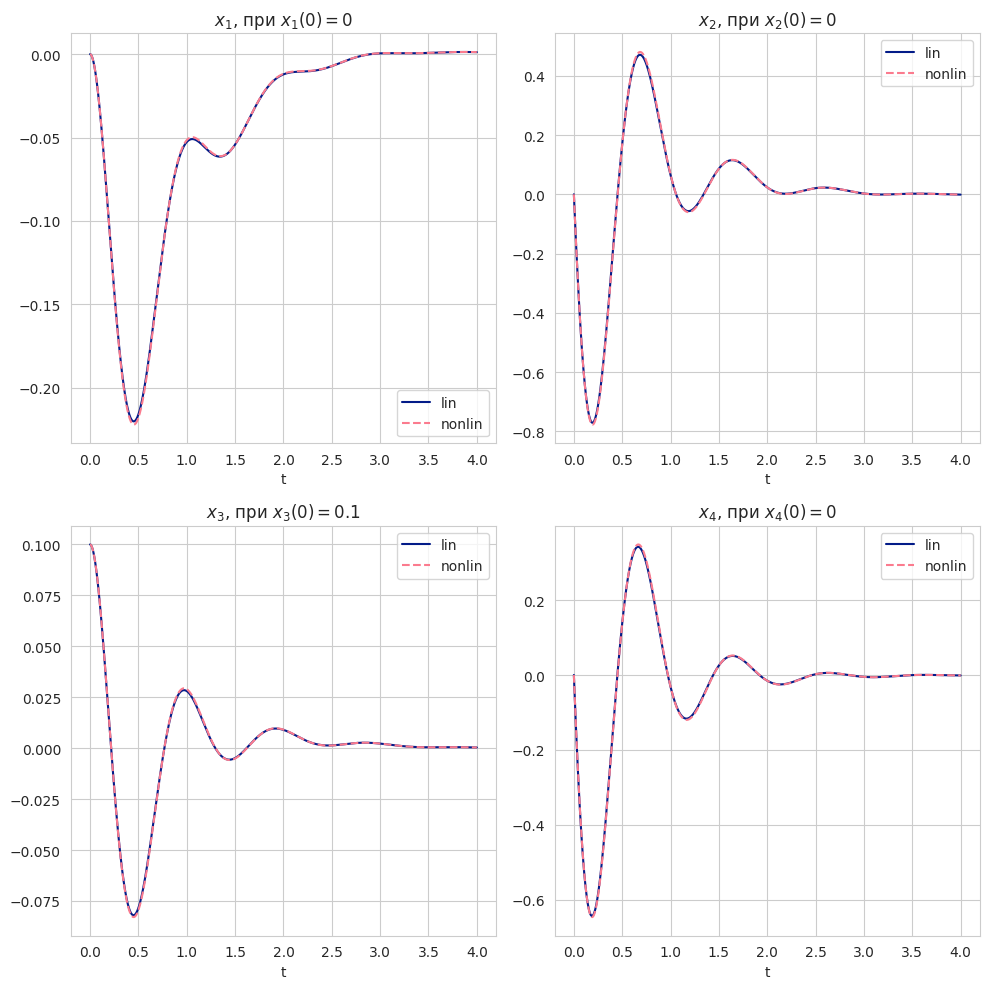

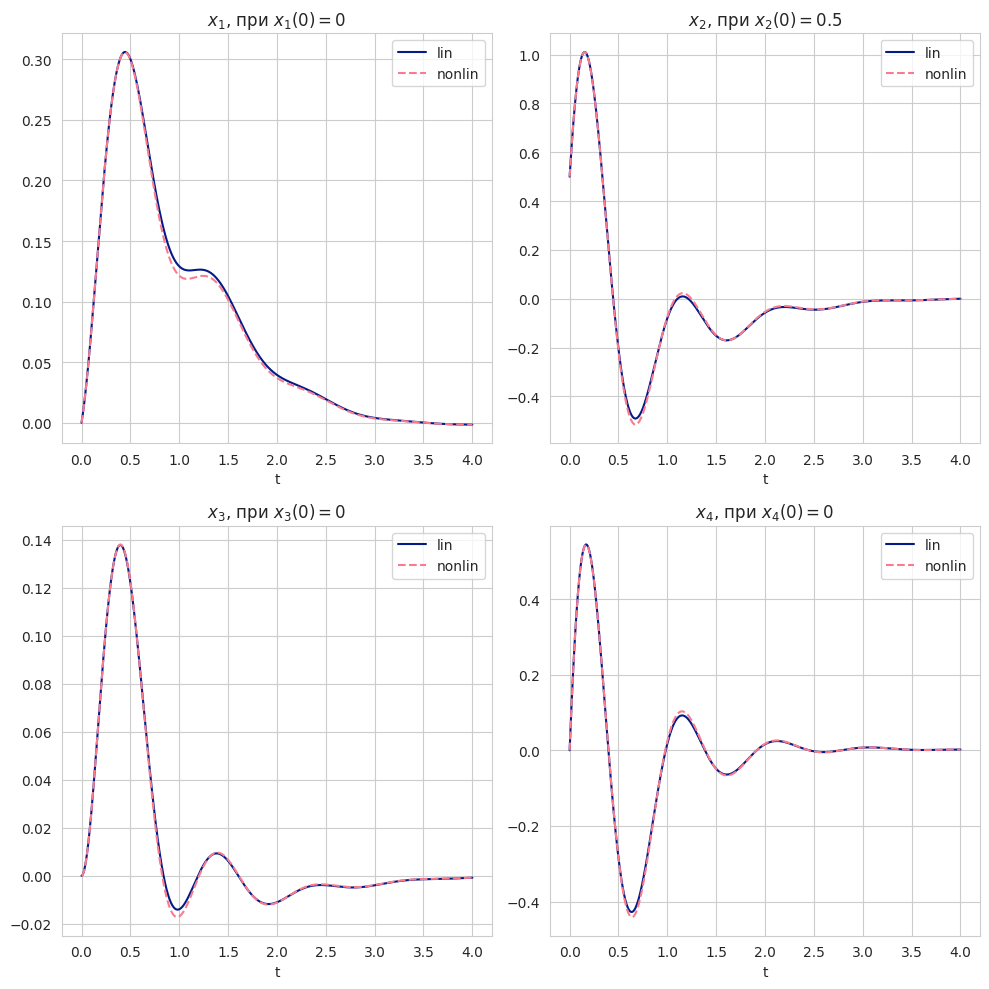

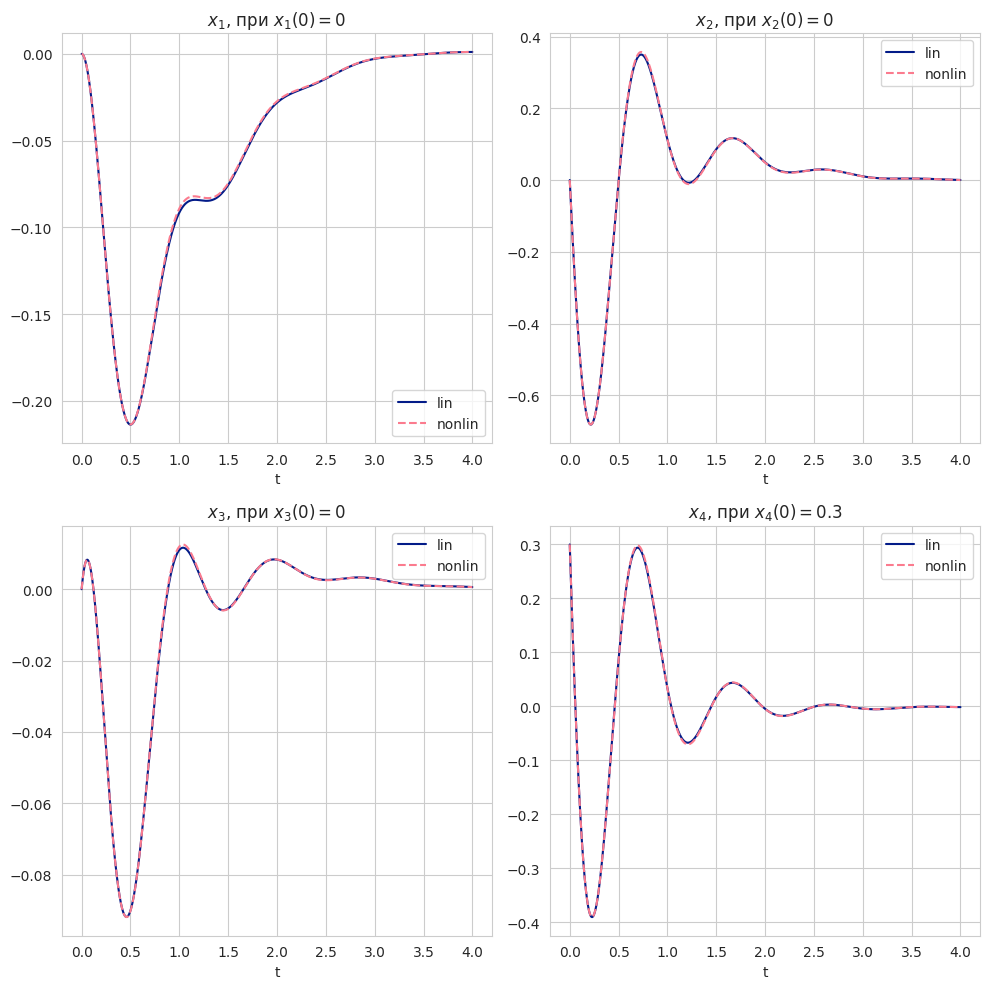

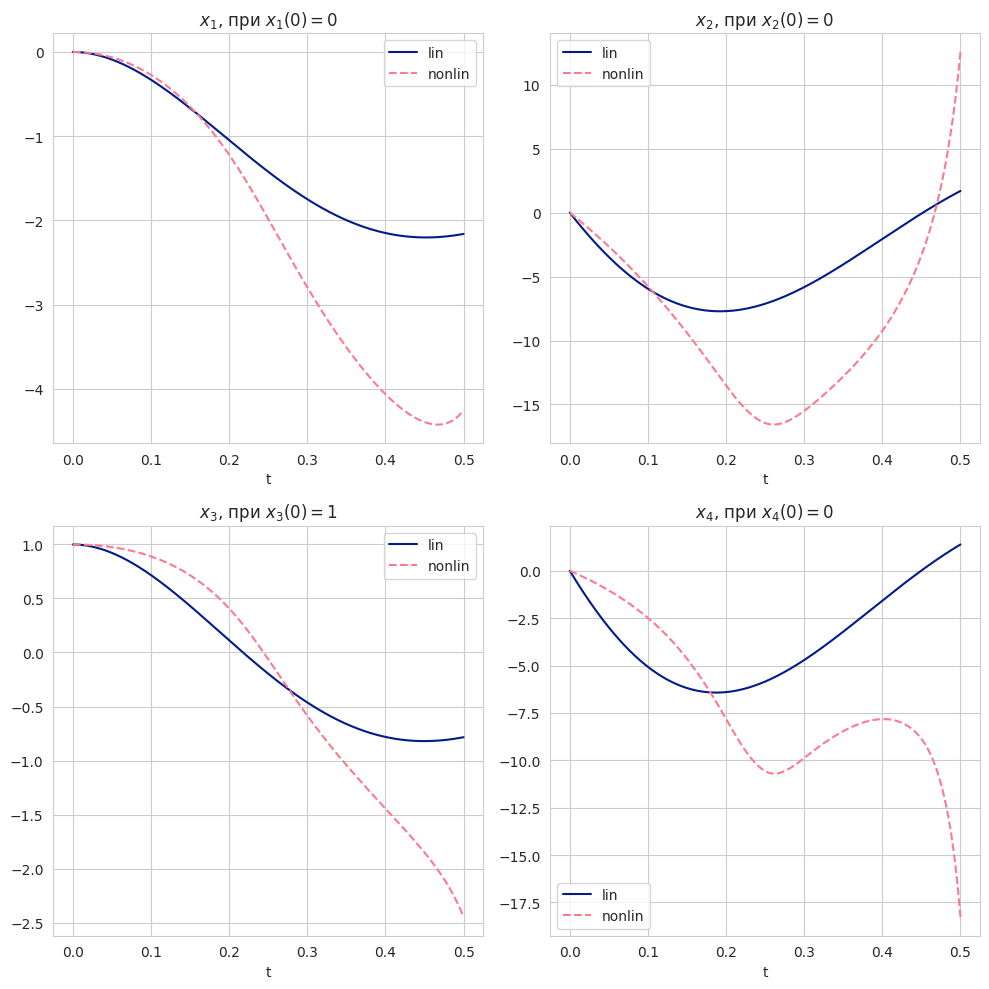

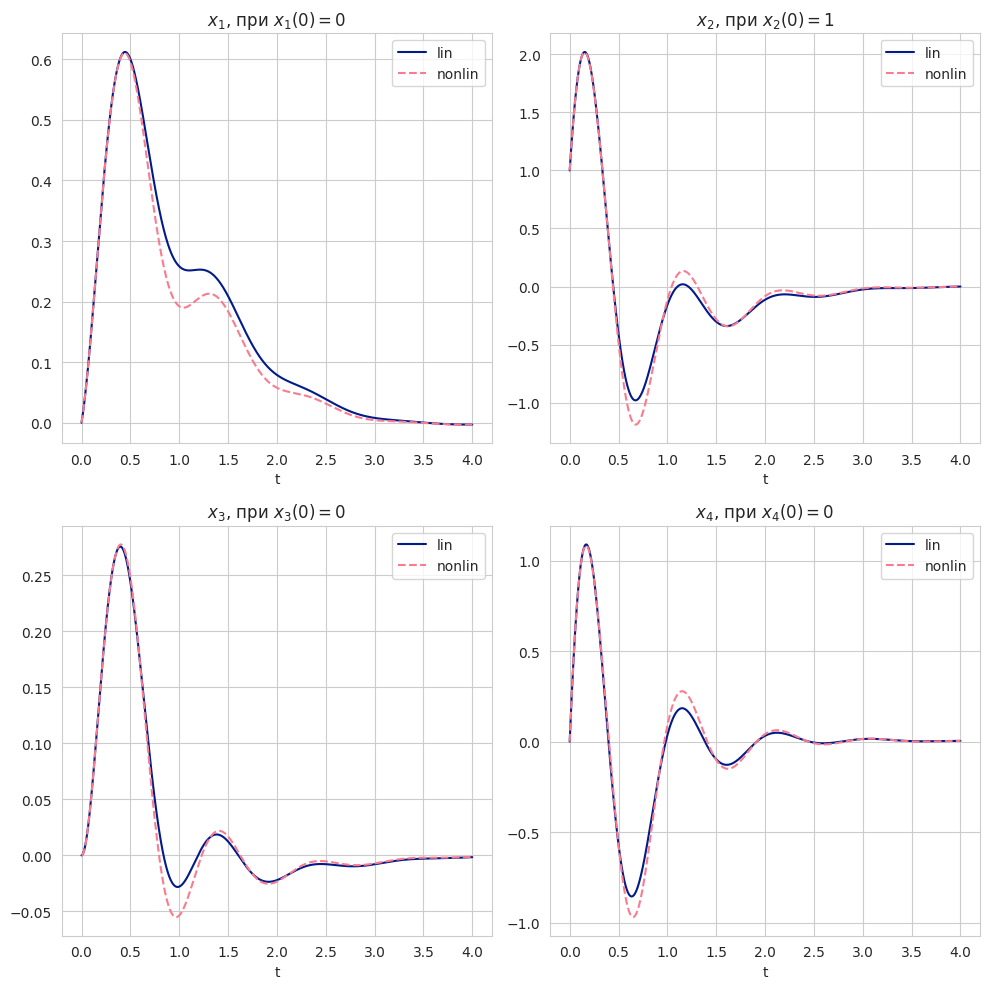

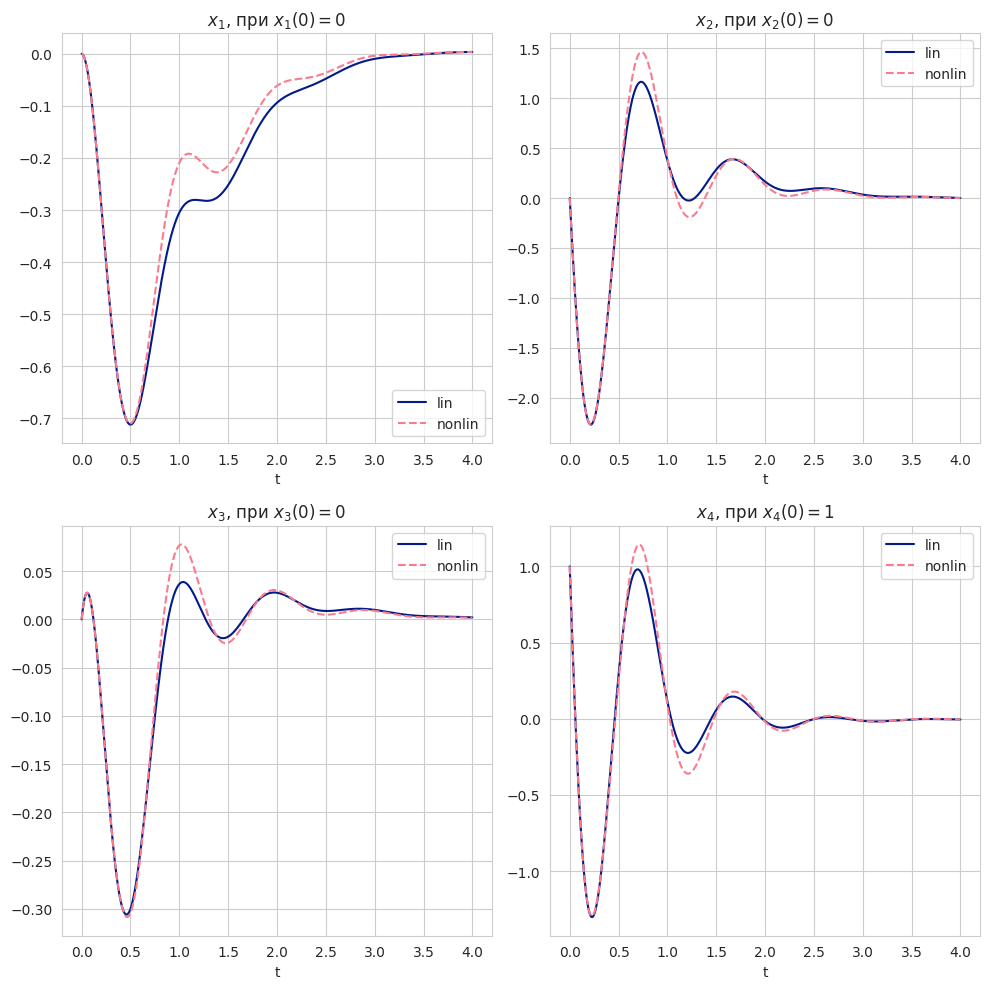

In [149]:
x0s = [
    [0, 0, 0.1, 0], [0, 0.5, 0, 0], [0, 0, 0, 0.3],
    [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]
]
ts = get_t(4)
ss_mod = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
for i, x0 in enumerate(x0s):
    if i == 3:
        ts = get_t(0.5)
    else:
        ts = get_t(4)
    task4_1_non_linear_compare_mod_control(ss_mod, ss_non_lin_4_1, x0, ts)

### Task 4.2

In [151]:
def task4_2_non_linear_compare_alphas_control(x0, ts):
    alphas = [0.1, 0.8, 1.5]
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    us = []
    for alpha in alphas:
        K = task4_get_K_LMI(A, B, alpha)
        print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
        print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
        ss_non_lin_4_2 = ctrl.NonlinearIOSystem(up_func, params={"K": K})
        ss_non_lin_4_2.set_inputs(2)
        resp_non_lin = ctrl.input_output_response(ss_non_lin_4_2, T=ts, X0=x0, U=np.zeros((2, len(ts))))
        us.append((K@resp_non_lin.states).reshape(-1))
        for i in range(4):
            ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
            ax[i//2, i%2].plot(ts, resp_non_lin.states[i], label=f"$\\alpha={alpha}$") 
            ax[i//2, i%2].set_xlabel('t') 
            ax[i//2, i%2].grid(True) 
            ax[i//2, i%2].legend() 
    plt.tight_layout()        
    plt.savefig(f'{SAVE_PATH}/task4_2_{"_".join([str(x) for x in x0])}.jpg')
    plt.show()
    
    plt.clf()
    plt.title(f"$u(t)$, $x_0=${x0}")
    plt.plot(ts, us[0], label=f"$\\alpha={alphas[0]}$")
    plt.plot(ts, us[1], label=f"$\\alpha={alphas[1]}$")
    plt.plot(ts, us[2], label=f"$\\alpha={alphas[2]}$")
    plt.legend()
    plt.savefig(f'{SAVE_PATH}/task4_2_u_{"_".join([str(x) for x in x0])}.jpg')

\[K = \begin{bmatrix}
  2.12 &  3.06 & -57.85 & -7.05
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.56 + 5.51j & -1.56 + -5.51j & -0.43 + 0.67j & -0.43 + -0.67j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  17.93 &  22.33 & -112.94 & -32.96
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.11 + 5.86j & -3.11 + -5.86j & -3.14 + 0.00j & -1.27 + 0.00j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  30.54 &  29.44 & -147.45 & -39.61
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.19 + 7.66j & -3.19 + -7.66j & -1.90 + 0.87j & -1.90 + -0.87j
\end{bmatrix}\]


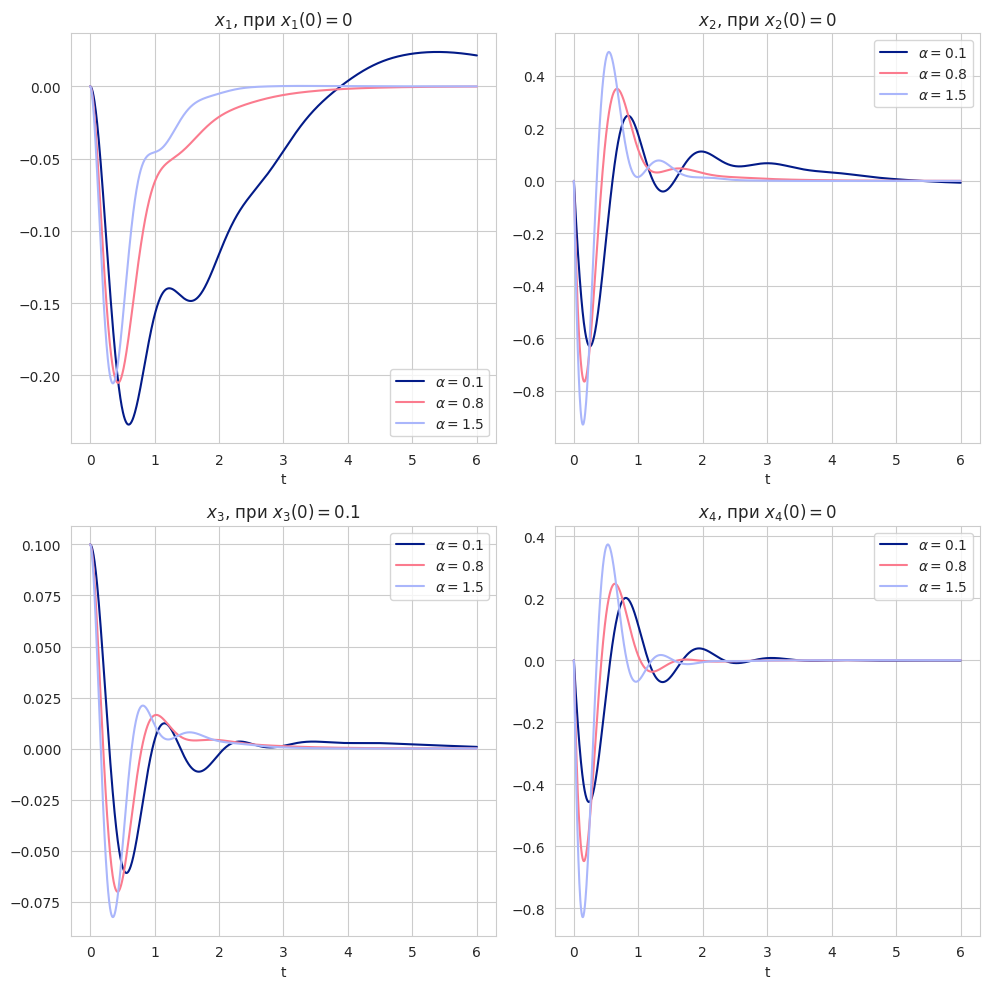

\[K = \begin{bmatrix}
  2.12 &  3.06 & -57.85 & -7.05
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.56 + 5.51j & -1.56 + -5.51j & -0.43 + 0.67j & -0.43 + -0.67j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  17.93 &  22.33 & -112.94 & -32.96
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.11 + 5.86j & -3.11 + -5.86j & -3.14 + 0.00j & -1.27 + 0.00j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  30.54 &  29.44 & -147.45 & -39.61
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.19 + 7.66j & -3.19 + -7.66j & -1.90 + 0.87j & -1.90 + -0.87j
\end{bmatrix}\]


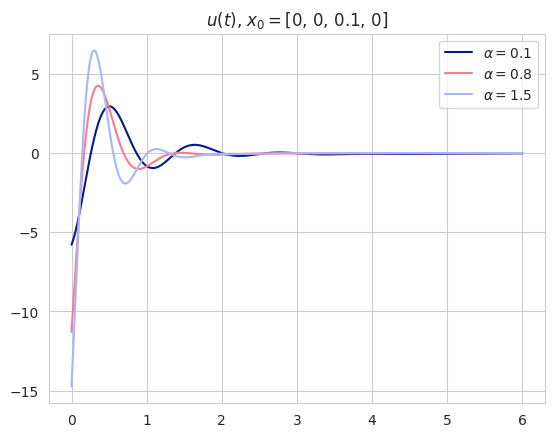

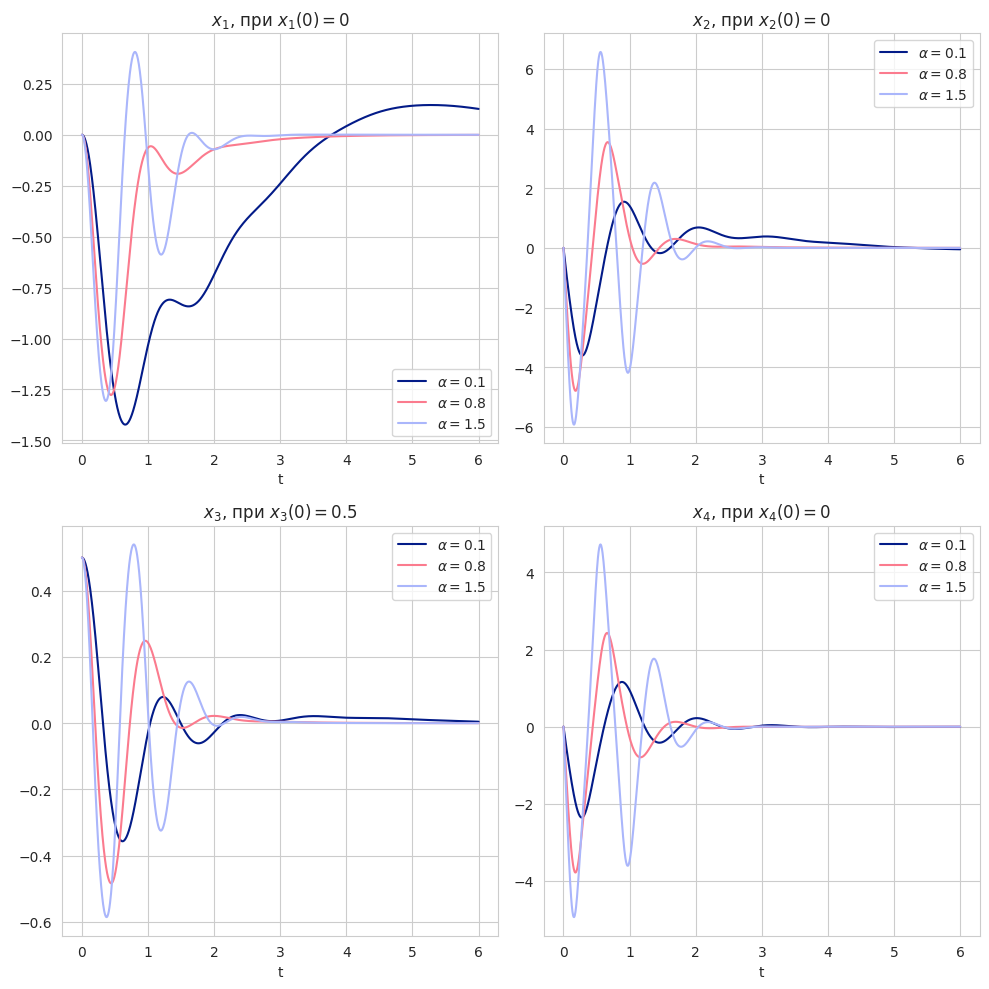

\[K = \begin{bmatrix}
  2.12 &  3.06 & -57.85 & -7.05
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.56 + 5.51j & -1.56 + -5.51j & -0.43 + 0.67j & -0.43 + -0.67j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  17.93 &  22.33 & -112.94 & -32.96
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.11 + 5.86j & -3.11 + -5.86j & -3.14 + 0.00j & -1.27 + 0.00j
\end{bmatrix}\]
\[K = \begin{bmatrix}
  30.54 &  29.44 & -147.45 & -39.61
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.19 + 7.66j & -3.19 + -7.66j & -1.90 + 0.87j & -1.90 + -0.87j
\end{bmatrix}\]


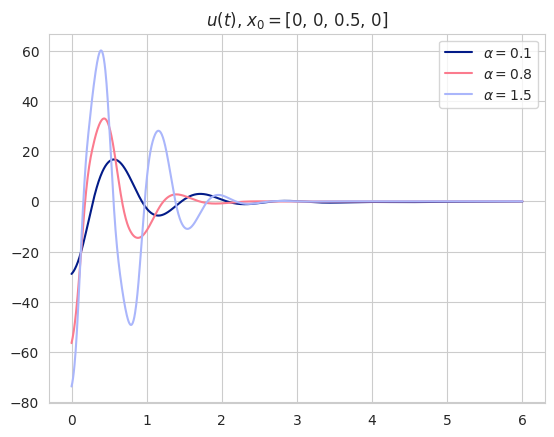

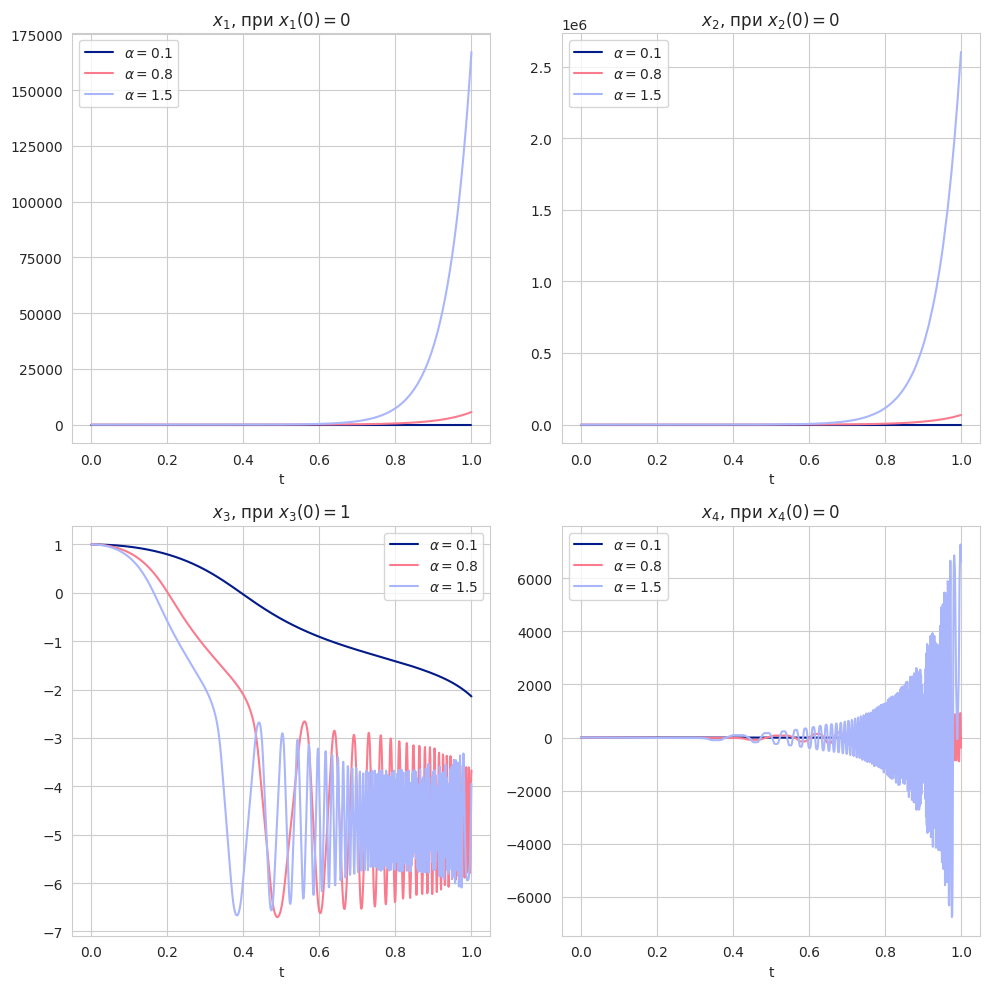

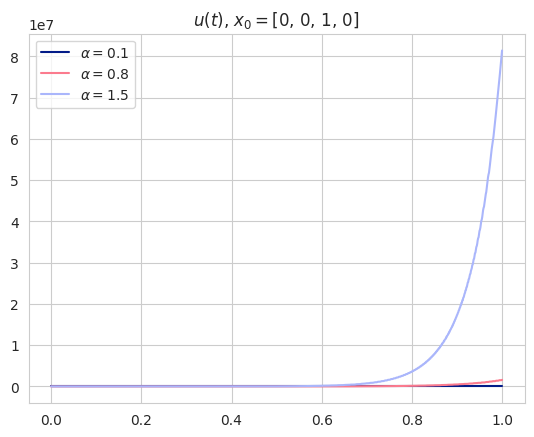

In [152]:
x0s = [
    [0, 0, 0.1, 0], [0, 0, 0.5, 0], [0, 0, 1, 0]
]
ts = get_t(6,0.005)
for i, x0 in enumerate(x0s):
    if i == 2:
        ts = get_t(1,0.001)
    task4_2_non_linear_compare_alphas_control(x0, ts)

### Task 4.3

In [157]:
def task4_3_non_linear_compare_alphas_control(alpha, ts):
    x0 = np.array([0, 0, 0.5, 0])
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    K, mu = task4_get_K_LMI_mu(A, B, alpha,x0.reshape((4,1)))
    print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
    ss_non_lin_4_3 = ctrl.NonlinearIOSystem(up_func, params={"K": K})
    ss_non_lin_4_3.set_inputs(2)
    
    ss_lin = ctrl.ss(A + B @ K, np.zeros_like(A), np.zeros_like(A), np.zeros_like(A))
    
    resp = ctrl.initial_response(ss_lin, T=ts, X0=x0)
    resp_non_lin = ctrl.input_output_response(ss_non_lin_4_3, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    fig.suptitle(f"$\\alpha={alpha}$")
    for i in range(4):
        ax[i//2, i%2].set_title(f"$x_{i+1}$, при $x_{i+1}(0) = {x0[i]}$")
        ax[i//2, i%2].plot(ts, resp_non_lin.states[i],label="nonlin") 
        ax[i//2, i%2].plot(ts, resp.states[i],label="linear") 
        
        ax[i//2, i%2].set_xlabel('t') 
        ax[i//2, i%2].grid(True) 
        ax[i//2, i%2].legend() 
    plt.tight_layout()
    plt.savefig(f'{SAVE_PATH}/task4_3_{alpha}.jpg')
    plt.show()
    
    plt.clf()
    plt.title(f"$u(t)$, $x_0=${x0}, $\\alpha={alpha}$")
    plt.plot(ts, (K@resp_non_lin.states).reshape(-1), label="nonlin")
    plt.plot(ts, (K@resp.states).reshape(-1), label="linear")
    plt.legend()
    plt.savefig(f'{SAVE_PATH}/task4_3_u_{alpha}.jpg')

In [158]:
print(cp.installed_solvers())

['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


\[K = \begin{bmatrix}
  0.03 &  0.30 & -21.60 & -5.02
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -4.43 + 0.00j & -0.10 + 0.00j & -0.10 + 0.78j & -0.10 + -0.78j
\end{bmatrix}\]


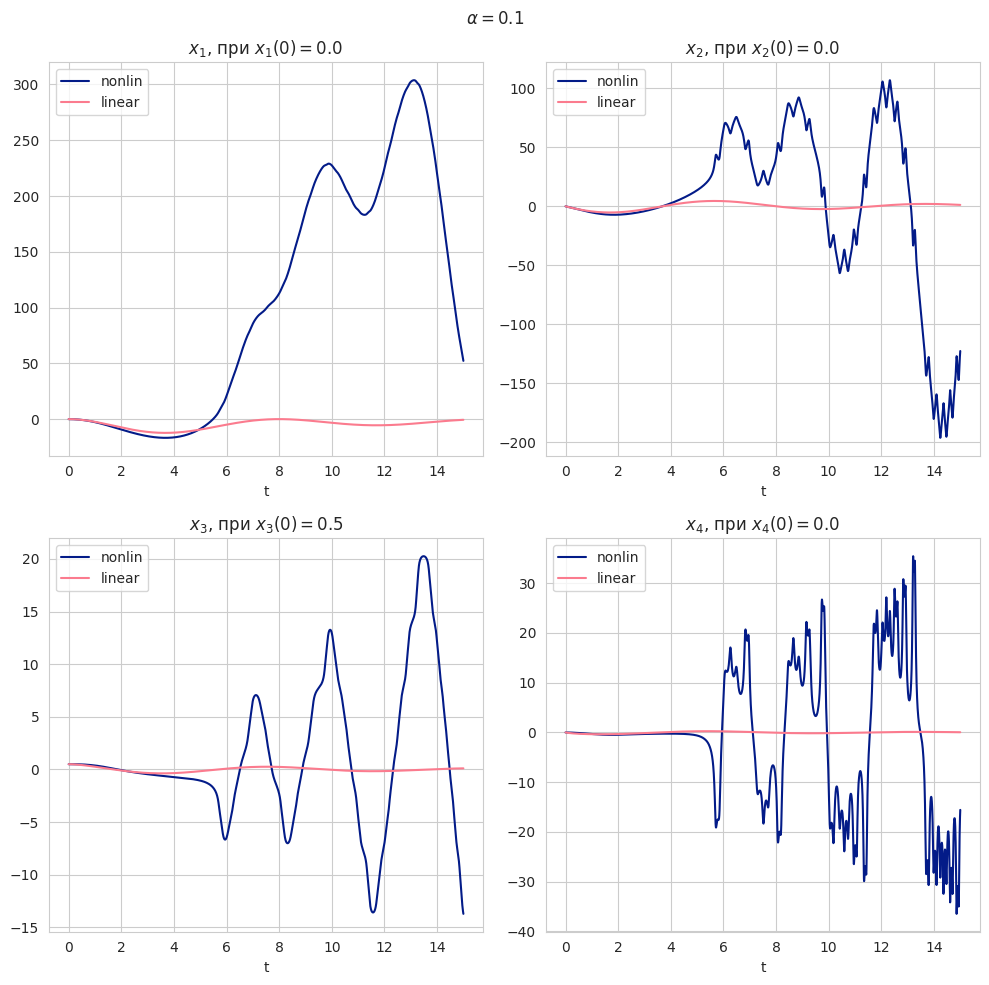

\[K = \begin{bmatrix}
  0.78 &  1.95 & -30.95 & -7.88
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -4.43 + 0.00j & -0.50 + 1.79j & -0.50 + -1.79j & -0.50 + 0.00j
\end{bmatrix}\]


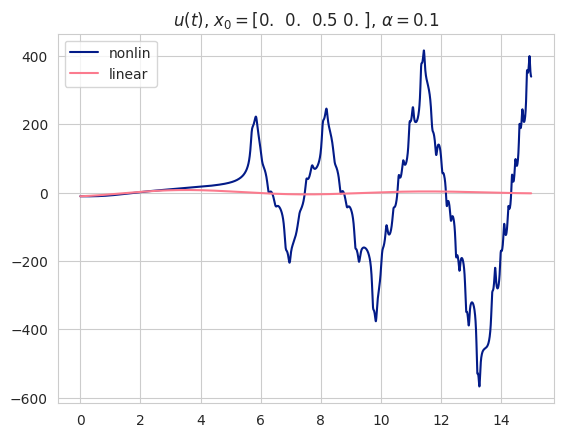

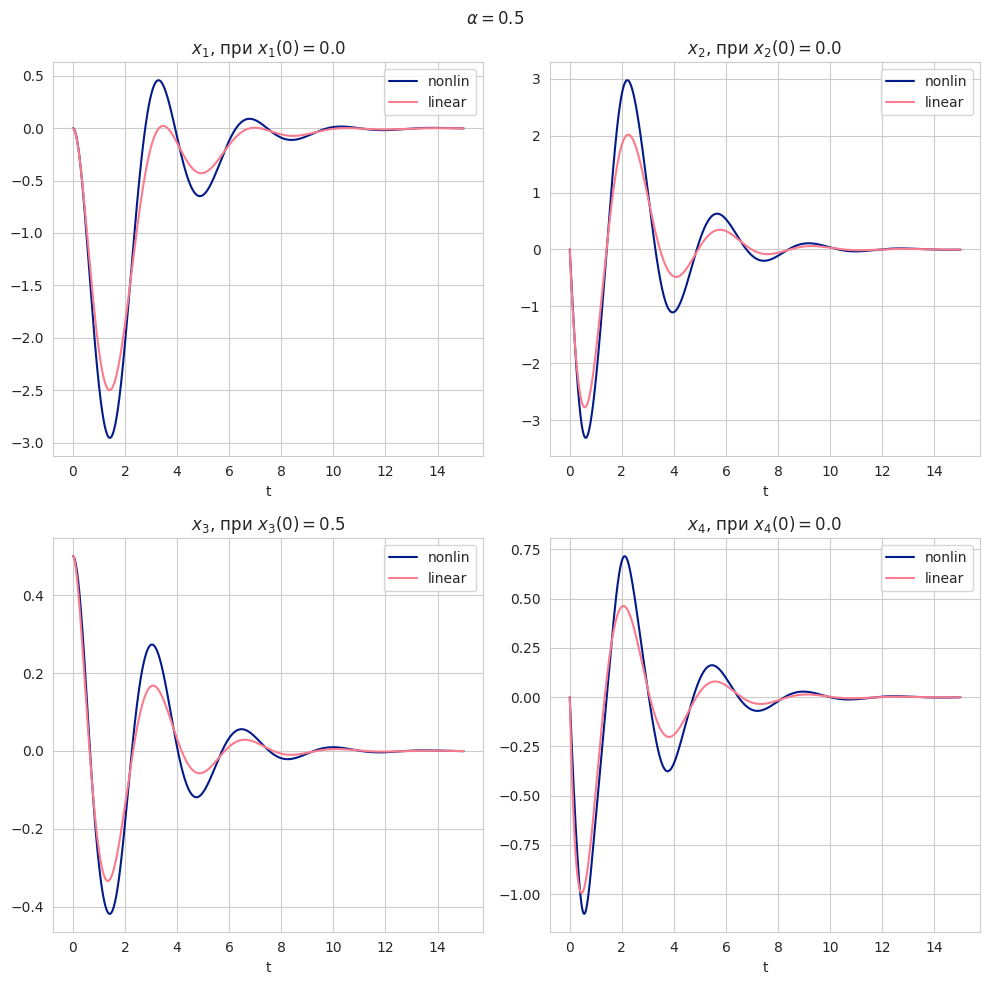

\[K = \begin{bmatrix}
  3.52 &  5.21 & -46.18 & -12.64
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -4.42 + 0.00j & -1.00 + 2.61j & -1.00 + -2.61j & -1.00 + 0.00j
\end{bmatrix}\]


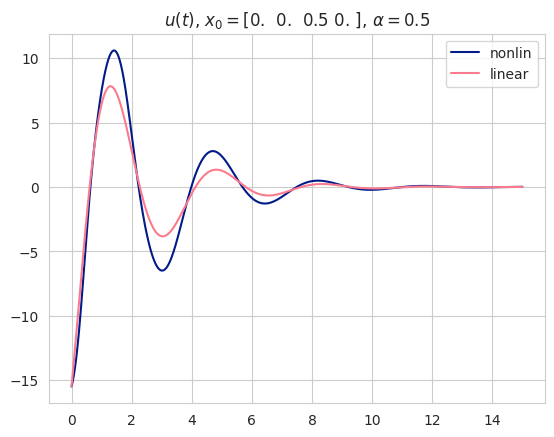

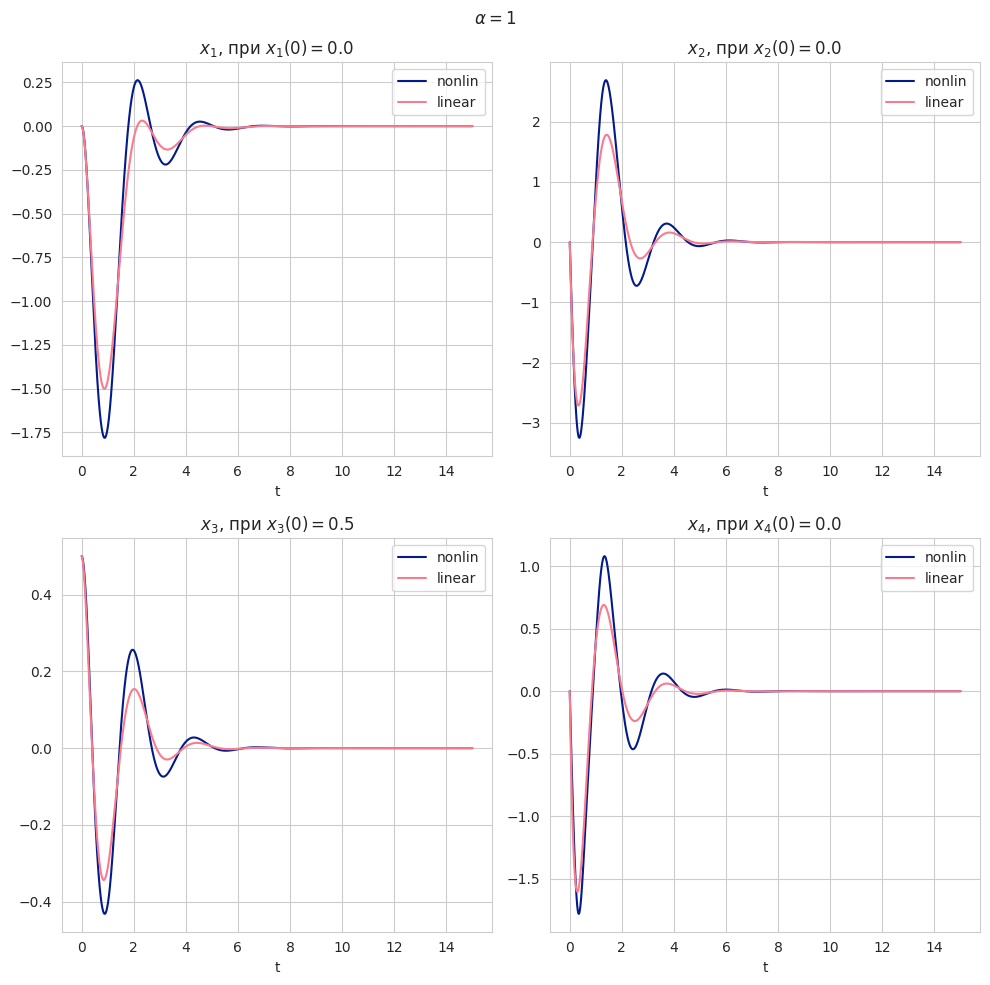

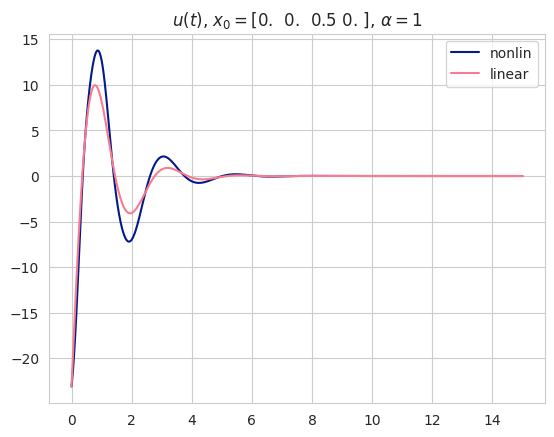

In [159]:
alphas = [
    0.1, 0.5, 1
]
ts = get_t(15,0.005)
for i, alpha in enumerate(alphas):
    # if i == 2:
    #     ts = get_t(1,0.001)
    task4_3_non_linear_compare_alphas_control(alpha, ts)

### Task 4.4

In [160]:
alpha

1

In [161]:
L = task4_get_L_LMI(A, C, alpha)
L

array([[ -5.6104778 ,  -7.79493736],
       [-11.64983024, -24.59637205],
       [  7.79478992,  -5.61074083],
       [ 14.79614097, -31.25047629]])

In [162]:
np.linalg.eigvals(A + L@C)

array([-3.60370058+8.32550475j, -3.60370058-8.32550475j,
       -2.00690873+0.53064111j, -2.00690873-0.53064111j])

In [163]:
def up_func_L(t, x, u, params):
    ''' 
    u[0] -- y_0
    u[1] -- y_1
    '''
    L = params.get('L', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ]) + L @ (C@x - u)

In [164]:
K = task4_get_K_LMI(A, B, 1)
K

array([[ 11.12542796,  13.0149425 , -87.53904547, -19.29429479]])

In [165]:
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A + L C) = {a2l.to_ltx(np.linalg.eigvals(A + L@C), print_out=False)}\]')

\[K = \begin{bmatrix}
  11.13 &  13.01 & -87.54 & -19.29
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.81 + 6.44j & -1.81 + -6.44j & -1.33 + 0.82j & -1.33 + -0.82j
\end{bmatrix}\]
\[L = \begin{bmatrix}
 -5.61 & -7.79\\
 -11.65 & -24.60\\
  7.79 & -5.61\\
  14.80 & -31.25
\end{bmatrix}\]
\[spec(A + L C) = \begin{bmatrix}
 -3.60 + 8.33j & -3.60 + -8.33j & -2.01 + 0.53j & -2.01 + -0.53j
\end{bmatrix}\]


In [166]:
ts = get_t(10)
ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": K})
ss_non_lin.set_inputs(2)

ss_non_lin_obs = ctrl.NonlinearIOSystem(up_func_L, params={"L": L, 'C': C})
ss_non_lin_obs.set_inputs(2)

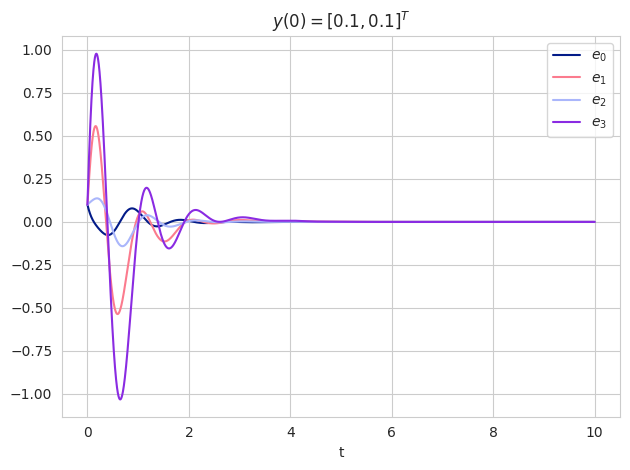

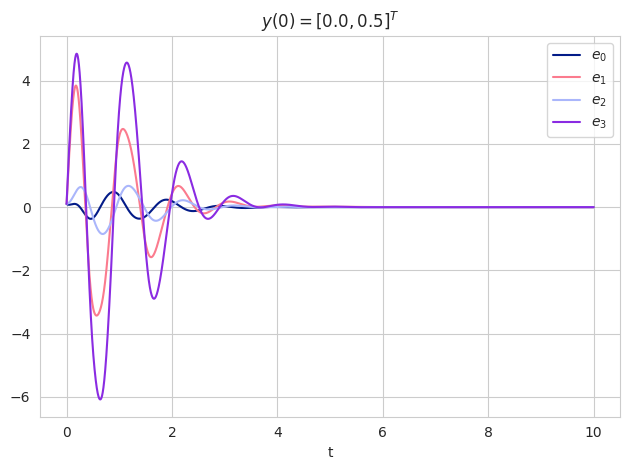

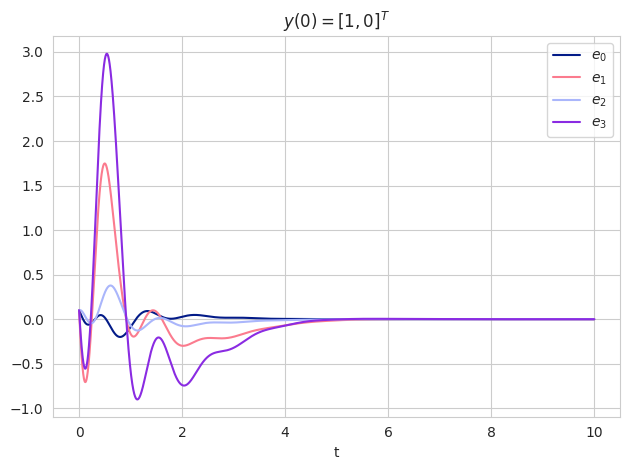

In [169]:
x0s = [[0.1, 0, 0.1, 0], [0, 0, 0.5, 0], [1, 0, 0, 0]]
for x0 in x0s:
    x0 = np.array(x0)
    resp_non_lin = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0, U=np.zeros((2, len(ts))))
    resp_non_lin_obs = ctrl.input_output_response(ss_non_lin_obs, T=ts, X0=x0 + 0.1, U=C @ resp_non_lin.states)
    err = resp_non_lin_obs.states - resp_non_lin.states
    for i in range(4):
        plt.plot(ts, err[i], label=f'$e_{i}$') 
        plt.xlabel('t') 
        plt.grid() 
        plt.legend() 
        plt.title(f'$y(0) = [{x0[0]}, {x0[2]}]^T$')
        
        plt.savefig(f'{SAVE_PATH}/task4_4_{x0[0]}_{x0[2]}.jpg')
    plt.tight_layout()
    plt.show()
    plt.close()

### Task 4.5

In [170]:
def up_func_K_L(t, x, u, params):
    ''' 
    x[:4] --  x
    x[4:] --  \hat{x}
    u -- trash
    '''
    L = params.get('L', np.zeros((1, 4)))
    K = params.get('K', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    u[0] = (K @ x[4:]).reshape(-1)[0]
    
    dxh =  np.array([
        x[4 + 1],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*l*np.sin(x[4 + 2])*x[4 + 3]**2 + m*g*np.cos(x[4 + 2])*np.sin(x[4 + 2]) + u[0] + u[1]*np.cos(x[4 + 2])/l),
        x[4 + 3],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*np.cos(x[4 + 2])*np.sin(x[4 + 2])*x[4 + 3]**2 + (M+m)*g*np.sin(x[4 + 2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[4 + 2])/l)
    ]) + L @ (C@x[4:] - C@x[:4])
    
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
    return np.hstack((dx, dxh))

In [171]:
alpha = 1
L = task4_get_L_LMI(A, C, alpha).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task4_get_K_LMI(A, B, alpha)
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A + L C) = {a2l.to_ltx(np.linalg.eigvals(A + L@C), print_out=False)}\]')

\[K = \begin{bmatrix}
  11.13 &  13.01 & -87.54 & -19.29
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.81 + 6.44j & -1.81 + -6.44j & -1.33 + 0.82j & -1.33 + -0.82j
\end{bmatrix}\]
\[L = \begin{bmatrix}
 -5.61 & -7.79\\
 -11.65 & -24.60\\
  7.79 & -5.61\\
  14.80 & -31.25
\end{bmatrix}\]
\[spec(A + L C) = \begin{bmatrix}
 -3.60 + 8.33j & -3.60 + -8.33j & -2.01 + 0.53j & -2.01 + -0.53j
\end{bmatrix}\]


In [172]:
def nonlin_lmi_full(x0, ts = get_t(10)):
    ss_non_lin = ctrl.NonlinearIOSystem(up_func_K_L, params={"K": K, "L": L, 'C': C})
    ss_non_lin.set_inputs(2)
    resp_non_lin_by_output = ctrl.input_output_response(ss_non_lin, T=ts, X0=np.hstack((x0, x0 + 0.1)), U=C @ resp_non_lin.states[:,:len(ts)])
    for i in range(4):
        plt.plot(ts, resp_non_lin_by_output.states[i], label=f'$x_{i}$') 
        plt.xlabel('t') 
        plt.legend() 
        plt.savefig(f'{SAVE_PATH}/task4_5_{alpha}.jpg')

\[K = \begin{bmatrix}
  11.13 &  13.01 & -87.54 & -19.29
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.81 + 6.44j & -1.81 + -6.44j & -1.33 + 0.82j & -1.33 + -0.82j
\end{bmatrix}\]
\[L = \begin{bmatrix}
 -5.61 & -7.79\\
 -11.65 & -24.60\\
  7.79 & -5.61\\
  14.80 & -31.25
\end{bmatrix}\]
\[spec(A + L C) = \begin{bmatrix}
 -3.60 + 8.33j & -3.60 + -8.33j & -2.01 + 0.53j & -2.01 + -0.53j
\end{bmatrix}\]


Text(0.5, 1.0, '$\\alpha$=1')

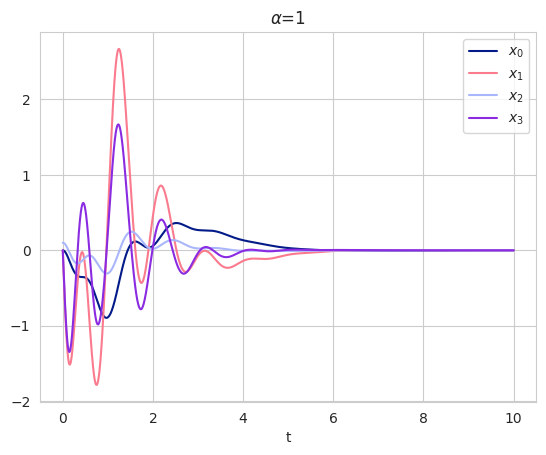

In [179]:
alpha = 1
L = task4_get_L_LMI(A, C, alpha).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task4_get_K_LMI(A, B, alpha)
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A + L C) = {a2l.to_ltx(np.linalg.eigvals(A + L@C), print_out=False)}\]')
nonlin_lmi_full(np.array([0, 0, 0.1, 0]))
plt.title(f"$\\alpha$={alpha}")

\[K = \begin{bmatrix}
  4.58 &  6.66 & -68.51 & -11.58
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -1.64 + 5.92j & -1.64 + -5.92j & -0.81 + 0.73j & -0.81 + -0.73j
\end{bmatrix}\]
\[L = \begin{bmatrix}
 -1.34 & -3.01\\
 -1.98 & -12.00\\
  3.01 & -1.34\\
  2.20 & -21.58
\end{bmatrix}\]
\[spec(A + L C) = \begin{bmatrix}
 -0.62 + 3.45j & -0.62 + -3.45j & -0.72 + 0.45j & -0.72 + -0.45j
\end{bmatrix}\]


Text(0.5, 1.0, '$\\alpha$=0.5')

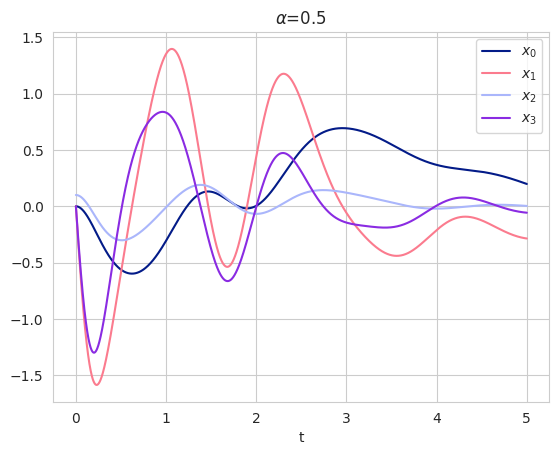

In [180]:
alpha = 0.5
L = task4_get_L_LMI(A, C, alpha).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task4_get_K_LMI(A, B, alpha)
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A + L C) = {a2l.to_ltx(np.linalg.eigvals(A + L@C), print_out=False)}\]')
nonlin_lmi_full(np.array([0, 0, 0.1, 0]),get_t(5))
plt.title(f"$\\alpha$={alpha}")

\[K = \begin{bmatrix}
  17.93 &  22.33 & -112.94 & -32.96
\end{bmatrix}\]
\[spec(A + B K) = \begin{bmatrix}
 -3.11 + 5.86j & -3.11 + -5.86j & -3.14 + 0.00j & -1.27 + 0.00j
\end{bmatrix}\]
\[L = \begin{bmatrix}
 -2.69 & -4.54\\
 -4.47 & -15.67\\
  4.54 & -2.69\\
  5.87 & -24.07
\end{bmatrix}\]
\[spec(A + L C) = \begin{bmatrix}
 -1.38 + 5.07j & -1.38 + -5.07j & -1.30 + 0.53j & -1.30 + -0.53j
\end{bmatrix}\]


Text(0.5, 1.0, '$\\alpha$=0.8')

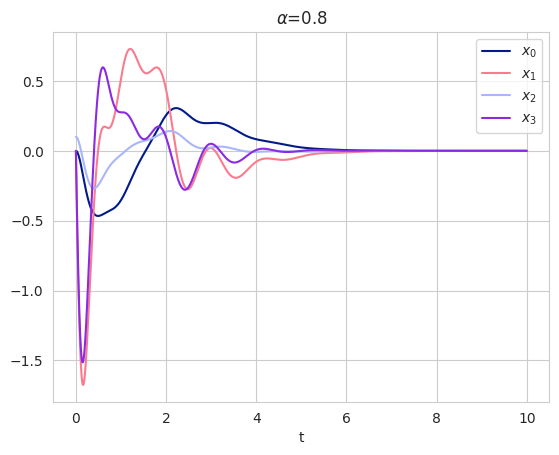

In [184]:
alpha = 0.8
L = task4_get_L_LMI(A, C, alpha).astype(np.float64)
Y = np.ones((B.shape[1], A.shape[0]))
K = task4_get_K_LMI(A, B, alpha)
print(f'\[K = {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + B K) = {a2l.to_ltx(np.linalg.eigvals(A + B @ K), print_out=False)}\]')
print(f'\[L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A + L C) = {a2l.to_ltx(np.linalg.eigvals(A + L@C), print_out=False)}\]')
nonlin_lmi_full(np.array([0, 0, 0.1, 0]))
plt.title(f"$\\alpha$={alpha}")

### Task 5

In [185]:
def up_func(t, x, u, params):
    ''' 
    u[0] -- u
    u[1] -- f
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    

\[Q = 0.1; R = 0.1; K_0 = \begin{bmatrix}
 -10.00 & -17.92 &  128.00 &  38.80
\end{bmatrix}\]
\[eig(A+BK_0) = \begin{bmatrix}
 -15.11 + 0.00j & -2.37 + 0.84j & -2.37 + -0.84j & -1.02 + 0.00j
\end{bmatrix}\]


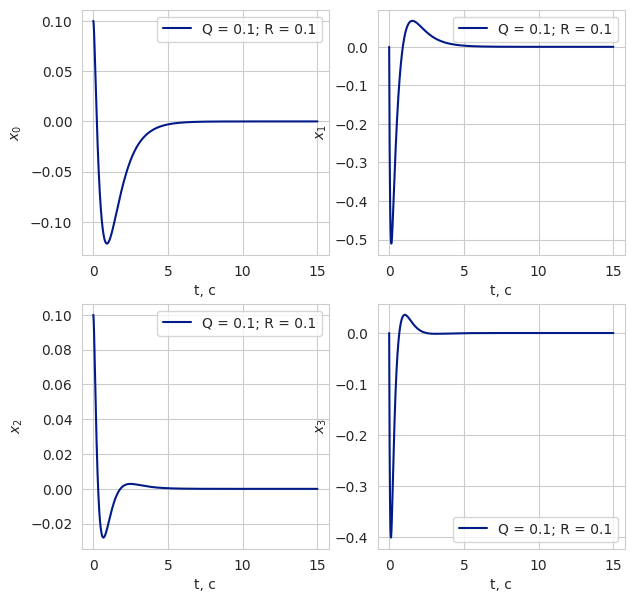

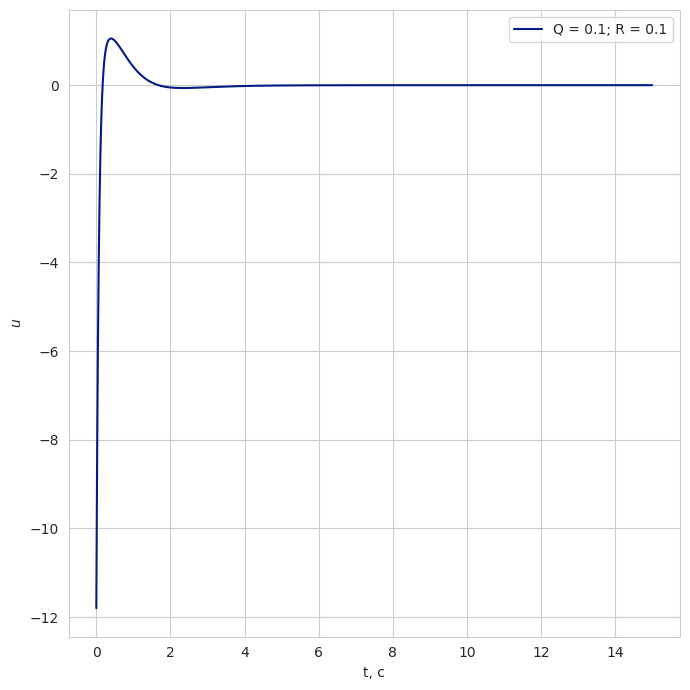

In [194]:
x0 = [0.1, 0, 0.1, 0]
values = np.array([1e-1])
ts = get_t(15)

fig, axs = plt.subplots(2, 2, figsize=(7, 7))
fig_u, axs_u = plt.subplots(1, figsize=(7, 7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

for indx in range(values.shape[0]):
    # print(f'======= Q = {values[indx]}; R = {values[::-1][indx]} ===========')
    Q = np.diag(np.ones((A.shape[0]))) / values[indx]
    R = np.diag(np.ones((B.shape[1]))) * values[indx]
    K, S, E = ctrl.lqr(A, B, Q, R)
    print(f'\[Q = {values[indx]}; R = {values[::-1][indx]}; K_{indx} = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[eig(A+BK_{indx}) = {a2l.to_ltx(E, print_out=False)}\]')
    ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": -K})
    ss_non_lin.set_inputs(2)    
    
    res = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0)
    
    xs = res.states
    us = (- K @ xs).reshape(-1)
    
    for i, state in enumerate(res.states):
        axs[i//2, i%2].plot(ts, state, label=f'Q = {values[indx]}; R = {values[::-1][indx]}') 
    axs_u.plot(ts, us, label=f'Q = {values[indx]}; R = {values[::-1][indx]}')
for i, state in enumerate(res.states):
        axs[i//2, i%2].legend()
        axs[i//2, i%2].set_xlabel('t, c')
        axs[i//2, i%2].set_ylabel(f'$x_{i}$')
axs_u.legend()
axs_u.set_xlabel('t, c')
axs_u.set_ylabel('$u$')
plt.tight_layout()
plt.show()
fig.savefig(f'{SAVE_PATH}/task5_1.jpg')
# fig_u.savefig(f'{SAVE_PATH}/task5_us.jpg')

\[Q = 0.01; R = 1.0; K_0 = \begin{bmatrix}
 -0.10 & -0.69 &  42.19 &  9.86
\end{bmatrix}\]
\[eig(A+BK_0) = \begin{bmatrix}
 -4.48 + 0.00j & -4.37 + 0.00j & -0.16 + 0.16j & -0.16 + -0.16j
\end{bmatrix}\]
\[Q = 0.1; R = 0.1; K_1 = \begin{bmatrix}
 -1.00 & -2.72 &  51.02 &  12.82
\end{bmatrix}\]
\[eig(A+BK_1) = \begin{bmatrix}
 -0.56 + 0.42j & -0.56 + -0.42j & -5.04 + 0.00j & -3.94 + 0.00j
\end{bmatrix}\]
\[Q = 1.0; R = 0.01; K_2 = \begin{bmatrix}
 -10.00 & -17.92 &  128.00 &  38.80
\end{bmatrix}\]
\[eig(A+BK_2) = \begin{bmatrix}
 -15.11 + 0.00j & -1.02 + 0.00j & -2.37 + 0.84j & -2.37 + -0.84j
\end{bmatrix}\]


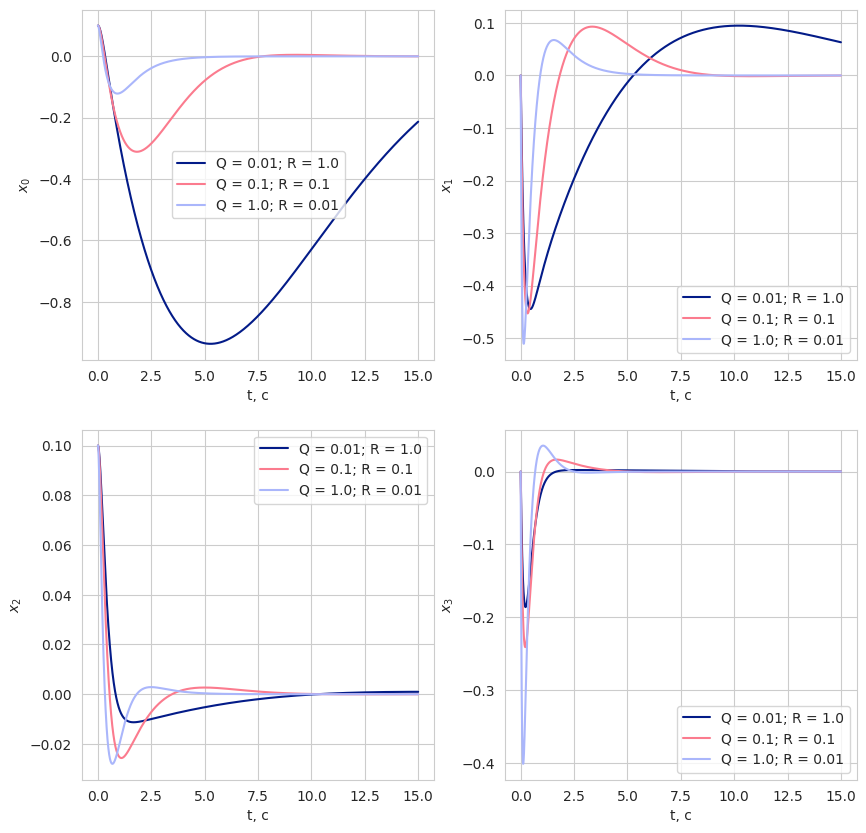

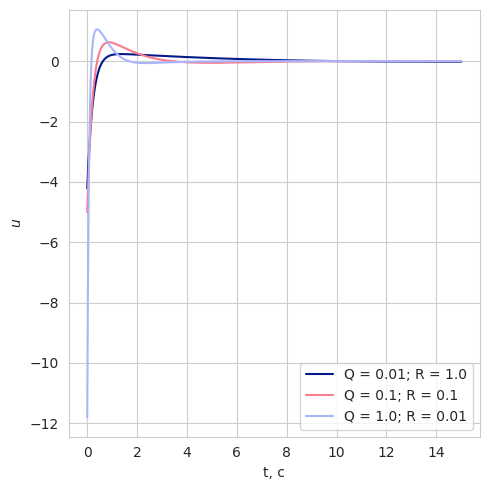

In [195]:
x0 = [0.1, 0, 0.1, 0]
values = np.array([1e-2, 1e-1, 1])
ts = get_t(15)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig_u, axs_u = plt.subplots(1, figsize=(5, 5))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

for indx in range(values.shape[0]):
    # print(f'======= Q = {values[indx]}; R = {values[::-1][indx]} ===========')
    Q = np.diag(np.ones((A.shape[0]))) * values[indx]
    R = np.diag(np.ones((B.shape[1]))) * values[::-1][indx]
    K, S, E = ctrl.lqr(A, B, Q, R)
    print(f'\[Q = {values[indx]}; R = {values[::-1][indx]}; K_{indx} = {a2l.to_ltx(K, print_out=False)}\]')
    print(f'\[eig(A+BK_{indx}) = {a2l.to_ltx(E, print_out=False)}\]')
    ss_non_lin = ctrl.NonlinearIOSystem(up_func, params={"K": -K})
    ss_non_lin.set_inputs(2)    
    
    res = ctrl.input_output_response(ss_non_lin, T=ts, X0=x0)
    
    xs = res.states
    us = (- K @ xs).reshape(-1)
    
    for i, state in enumerate(res.states):
        axs[i//2, i%2].plot(ts, state, label=f'Q = {values[indx]}; R = {values[::-1][indx]}') 
    axs_u.plot(ts, us, label=f'Q = {values[indx]}; R = {values[::-1][indx]}')
for i, state in enumerate(res.states):
        axs[i//2, i%2].legend()
        axs[i//2, i%2].set_xlabel('t, c')
        axs[i//2, i%2].set_ylabel(f'$x_{i}$')
axs_u.legend()
axs_u.set_xlabel('t, c')
axs_u.set_ylabel('$u$')
plt.tight_layout()
plt.show()
fig.savefig(f'{SAVE_PATH}/task5_1.jpg')
fig_u.savefig(f'{SAVE_PATH}/task5_us.jpg')

5.3

In [196]:
def up_func(t, x, u, params):
    ''' 
    u[0] -- u
    u[1] -- f
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])

In [197]:
def up_func_K_f(t, x, u, params):
    ''' 
    u -- trash
    '''
    K = params.get('K', np.zeros((1, 4)))
    u[0] = (K @ x).reshape(-1)[0]

    dx =  np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ])
    
    D = params.get('D', np.zeros((1, 4)))
    std_f = params.get('std_f', 1)
    noise = np.random.normal(0, std_f, (1, 1))
    f = (D @ noise).reshape(-1)
    dx += f
    
    return dx
    
def up_func_LQE(t, x, u, params):
    ''' 
    u[0] -- y_0
    u[1] -- y_1
    '''
    L = params.get('L', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    
    return np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ]) + L @ (C@x - u)
    
def generate_Kalman(a, c, std_q, std_r):
    q, r = np.diag(std_q)**2, np.diag(std_r)**2
    # q, r = np.linalg.inv(q), np.linalg.inv(r)
    l, p, _ = ctrl.lqe(a, np.eye(4), c, q, r)
    print(f'\[Q = {std_q[0]}; R = {std_r[0]}; L = {a2l.to_ltx(l, print_out=False)}\]')
    return l

\[Q = 0.01; R = 0.01; L = \begin{bmatrix}
  2.75 &  2.69\\
  6.90 &  16.83\\
  2.69 &  8.00\\
  12.06 &  35.08
\end{bmatrix}\]


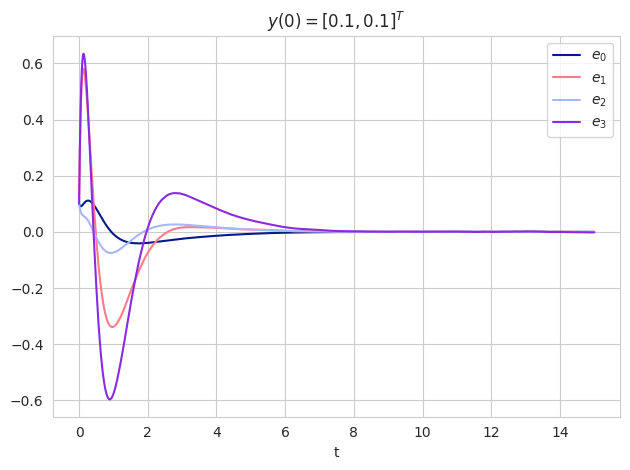

In [199]:
std_q, std_r = [0.01] * 4, [0.01] * 2
L = generate_Kalman(A, C, std_q, std_r)
x0 = np.array([0.1, 0, 0.1, 0])
ss_non_lin_f = ctrl.NonlinearIOSystem(up_func_K_f, params={"D": D, "std_f": std_q[0], 'K': -K})
ss_non_lin_f.set_inputs(2)
resp_non_lin_f = ctrl.input_output_response(ss_non_lin_f, T=ts, X0=x0, U=np.zeros((2, len(ts))))

ss_non_lin_LQE = ctrl.NonlinearIOSystem(up_func_LQE, params={"L": -L, "C": C})
ss_non_lin_LQE.set_inputs(2)

resp_non_lin_LQE = ctrl.input_output_response(ss_non_lin_LQE, T=ts, X0=x0 + 0.1, U=C @ resp_non_lin_f.states)
err = resp_non_lin_LQE.states - resp_non_lin_f.states
for i in range(4):
    plt.plot(ts, err[i], label=f'$e_{i}$') 
    plt.xlabel('t') 
    plt.grid() 
    plt.legend() 
    plt.title(f'$y(0) = [{x0[0]}, {x0[2]}]^T$')
    plt.savefig(f'{SAVE_PATH}/task5_3.jpg')
plt.tight_layout()
plt.show()

5.4

\[Q = 0.1; R = 0.1; L = \begin{bmatrix}
  2.75 &  2.69\\
  6.90 &  16.83\\
  2.69 &  8.00\\
  12.06 &  35.08
\end{bmatrix}\]
\[Q = 0.1; R = 0.1; L = \begin{bmatrix}
 -2.75 & -2.69\\
 -6.90 & -16.83\\
 -2.69 & -8.00\\
 -12.06 & -35.08
\end{bmatrix}\]
\[spec(A+LC) = \begin{bmatrix}
 -0.94 + 0.50j & -0.94 + -0.50j & -3.88 + 0.00j & -4.99 + 0.00j
\end{bmatrix}\]
\[Q = 1; R = 1; K= \begin{bmatrix}
  1.00 &  2.72 & -51.02 & -12.82
\end{bmatrix}\]
\[spec(A + BK) = \begin{bmatrix}
 -5.04 + 0.00j & -3.94 + 0.00j & -0.56 + 0.42j & -0.56 + -0.42j
\end{bmatrix}\]


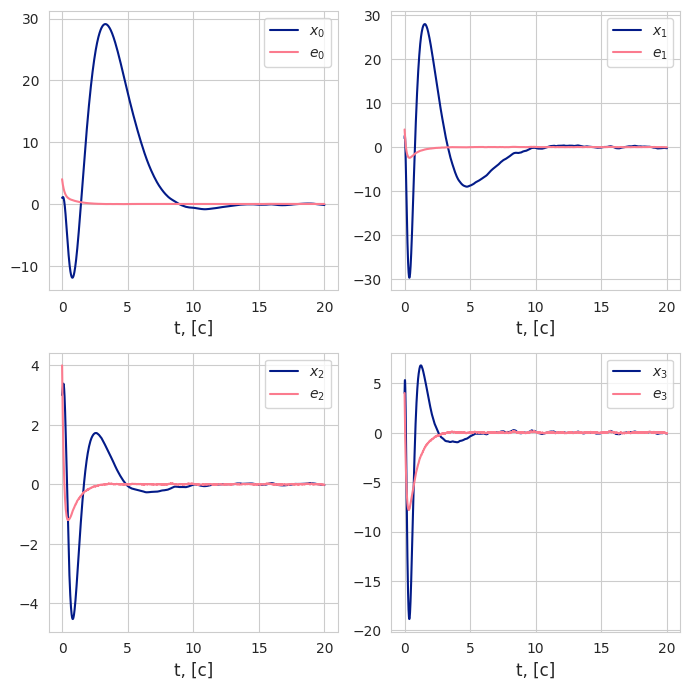

In [208]:
std_q, std_r = [0.1] * 4, [0.1] * 2
L = -generate_Kalman(A, C, std_q, std_r)
print(f'\[Q = {std_q[0]}; R = {std_r[0]}; L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A+LC) = {a2l.to_ltx(np.linalg.eigvals(A + L @ C), print_out=False)}\]')


Q = np.diag(np.ones((A.shape[0]))) * 1
R = np.diag(np.ones((B.shape[1]))) * 1
K, S, E = ctrl.lqr(A, B, Q, R)
K = -K
print(f'\[Q = {1}; R = {1}; K= {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + BK) = {a2l.to_ltx(E, print_out=False)}\]')

new_A = np.block([[A + B @ K, -B @ K], [np.zeros((A.shape[0], K.shape[1] * 2 - C.shape[1])), A + L @ C]])
new_B = np.block([[np.diag([1] * 4), np.zeros((4, 2))], [np.diag([1] * 4), L]])

ts = get_t(20)

f, xi = np.random.normal(0, std_q, (len(ts), 4)), np.random.normal(0, std_r, (len(ts), 2))
u = np.hstack([f, xi])
ss = ctrl.ss(new_A, new_B, 0 * new_A, 0 * new_B)
resp = ctrl.forced_response(ss, T=ts, U=u.T, X0=np.array([1, 2, 3, 4, 4, 4, 4, 4]))

fig, axs = plt.subplots(2, 2, figsize=(7, 7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

for i, state in enumerate(resp.states[:4]):
        axs[i//2, i%2].plot(ts, state, label=f'$ x_{i} $') 
        axs[i//2, i%2].plot(ts, resp.states[i+4], label=f'$ e_{i} $') 

for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
#     axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/task5_LQG_lin.jpg')

5.5

In [209]:
def up_func_LQG(t, x, u, params):
    ''' 
    x[:4] --  x
    x[4:] --  \hat{x}
    u -- trash
    '''
    L = params.get('L', np.zeros((1, 4)))
    K = params.get('K', np.zeros((1, 4)))
    C = params.get('C', np.zeros((1, 4)))
    D = params.get('D', np.zeros((1, 4)))
    std_f = params.get('std_f', 1)
    noise = np.random.normal(0, std_f, (1, 1))
    f = (D @ noise).reshape(-1)
    
    u[0] = (K @ x[4:]).reshape(-1)[0]
    
    dxh =  np.array([
        x[4 + 1],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*l*np.sin(x[4 + 2])*x[4 + 3]**2 + m*g*np.cos(x[4 + 2])*np.sin(x[4 + 2]) + u[0] + u[1]*np.cos(x[4 + 2])/l),
        x[4 + 3],
        1 / (M + m*np.sin(x[4 + 2])**2) * (-m*np.cos(x[4 + 2])*np.sin(x[4 + 2])*x[4 + 3]**2 + (M+m)*g*np.sin(x[4 + 2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[4 + 2])/l)
    ]) + L @ (C@x[4:] - C@x[:4])
    
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u[0] + u[1]*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*g*u[1]/(m*l**2) + u[0]*np.cos(x[2])/l)
    ]) + f
    
    return np.hstack((dx, dxh))

In [210]:
x0 = np.array([0.1, 0, 0.1, 0])
std_q, std_r = [0.1] * 4, [0.1] * 2
L = -generate_Kalman(A, C, std_q, std_r)
print(f'\[Q = {std_q[0]}; R = {std_r[0]}; L = {a2l.to_ltx(L, print_out=False)}\]')
print(f'\[spec(A+LC) = {a2l.to_ltx(np.linalg.eigvals(A + L @ C), print_out=False)}\]')


Q = np.diag(np.ones((A.shape[0]))) * 1
R = np.diag(np.ones((B.shape[1]))) * 1
K, S, E = ctrl.lqr(A, B, Q, R)
K = -K
print(f'\[Q = {1}; R = {1}; K= {a2l.to_ltx(K, print_out=False)}\]')
print(f'\[spec(A + BK) = {a2l.to_ltx(E, print_out=False)}\]')

ss_non_lin_LQG = ctrl.NonlinearIOSystem(up_func_LQG, params={"L": L, "C": C, "D": D, "std_f": std_q[0], 'K': K})
ss_non_lin_LQG.set_inputs(2)

resp_non_lin_LQG= ctrl.input_output_response(ss_non_lin_LQG, T=ts, X0=np.hstack((x0, x0 + 0.1)), U=np.zeros((2, len(ts))))

\[Q = 0.1; R = 0.1; L = \begin{bmatrix}
  2.75 &  2.69\\
  6.90 &  16.83\\
  2.69 &  8.00\\
  12.06 &  35.08
\end{bmatrix}\]
\[Q = 0.1; R = 0.1; L = \begin{bmatrix}
 -2.75 & -2.69\\
 -6.90 & -16.83\\
 -2.69 & -8.00\\
 -12.06 & -35.08
\end{bmatrix}\]
\[spec(A+LC) = \begin{bmatrix}
 -0.94 + 0.50j & -0.94 + -0.50j & -3.88 + 0.00j & -4.99 + 0.00j
\end{bmatrix}\]
\[Q = 1; R = 1; K= \begin{bmatrix}
  1.00 &  2.72 & -51.02 & -12.82
\end{bmatrix}\]
\[spec(A + BK) = \begin{bmatrix}
 -5.04 + 0.00j & -3.94 + 0.00j & -0.56 + 0.42j & -0.56 + -0.42j
\end{bmatrix}\]


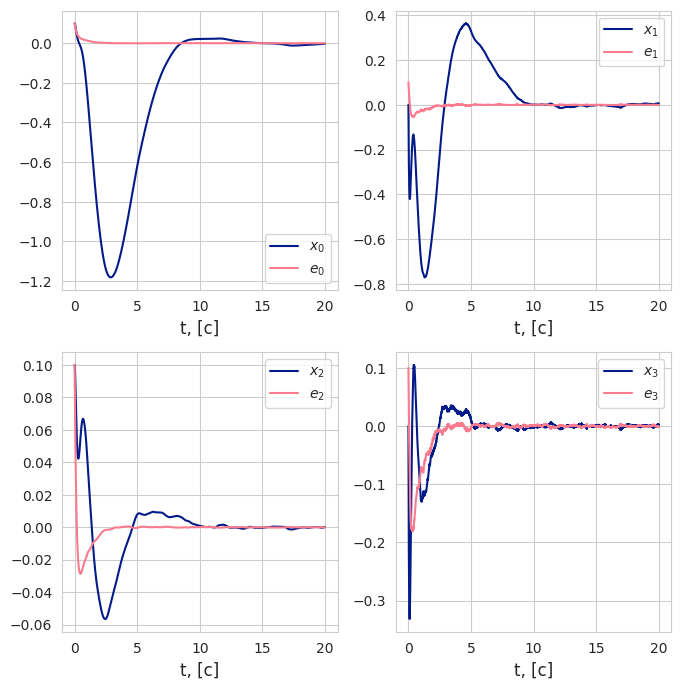

In [211]:
fig, axs = plt.subplots(2, 2,figsize=(7,7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

for i, state in enumerate(resp.states[:4]):
        axs[i//2, i%2].plot(ts, resp_non_lin_LQG.states[i], label=f'$ x_{i} $') 
        axs[i//2, i%2].plot(ts, resp_non_lin_LQG.states[i + 4] - resp_non_lin_LQG.states[i], label=f'$ e_{i} $') 

for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
#     axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/task5_LQG_non_lin.jpg')

## Task 6

6.1

In [212]:
A_1 = A

B_1 = B

B_2 = D @ (np.array(list(range(4))) / 3).reshape((1,-1))

A_2 = np.array([
    [0, 1, 0, 0],
    [-1, 0, 0, 0],
    [0, 0, 0, 2],
    [0, 0, -2, 0],
])

C_1 = C

D_1 = np.array([[0, 0, 0, 0], [0, 0, 0, 0]])

C_2 = np.array([[0, 0, 1, 0]])

D_2 = np.array([[0, 0, 0, 0]])

In [213]:
P_1 = cp.Variable((A_1.shape[0],D_2.shape[1]))
Y_1 = cp.Variable((B_1.shape[1],B_2.shape[1])) 
prob = cp.Problem(cp.Maximize(0),[C_2 @ P_1 + D_2 == 0, P_1 @ A_2 - A_1 @ P_1 == B_1 @ Y_1 + B_2])
prob.solve(solver="CLARABEL")

0.0

In [214]:
ts = get_t()
w_sys = ctrl.ss(A_2, np.zeros((4,1)), np.zeros((1, 4)), 0)
w = ctrl.initial_response(w_sys, X0=[0.5, 0.5, 0.5, 0.5], T=ts).states

In [215]:
B_2

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.66666667, 1.33333333, 2.        ]])

In [216]:
Y = np.ones((B.shape[1], A.shape[0]))
G = np.diag([-1, -2, -3, -4])
K_1 = task32_get_K(A_1, B_1, G, Y)

new_g = Gs[0]
new_y = np.ones((A.shape[0], C.shape[0]))

K_2 = Y_1.value - K_1 @ P_1.value
K_2

array([[ 1.70068027, -1.4829932 ,  0.80952381, -4.31292517]])

In [217]:
def up_func_comp(t, x, u, params):
    w = u.copy()
    f = ((np.array(list(range(4))) / 3).reshape((1,-1)) @ w).reshape(-1)[0]
    u = (K_1@x + K_2@w).reshape(-1)[0]
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u + f*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*f/(m*l**2) + u*np.cos(x[2])/l)
    ]) 
    return dx
    
non_lin_sys_comp = ctrl.NonlinearIOSystem(up_func_comp)
non_lin_sys_comp.set_inputs(4)

In [226]:
def compare_comp(x0):
    non_lin_sys_comp = ctrl.NonlinearIOSystem(up_func_comp)
    non_lin_sys_comp.set_inputs(4)
    resp_non_lin_comp = ctrl.input_output_response(non_lin_sys_comp, T=ts, X0=x0, U=w)
    lin_sys_comp = ctrl.ss(A_1 + B_1@K_1, B_2 + B_1@K_2, C_2, D_2)
    resp_lin_comp= ctrl.input_output_response(lin_sys_comp, T=ts, X0=x0, U=w)
    plt.plot(ts, resp_non_lin_comp.states[2], label="nonlinear")
    plt.plot(ts, resp_lin_comp.states[2], "--", label="linear")
    plt.title(f"$x_0$={x0}")
    plt.legend()
    plt.savefig(f'{SAVE_PATH}/task6_1_{x0[0]}_{x0[1]}_{x0[2]}_{x0[3]}.jpg')

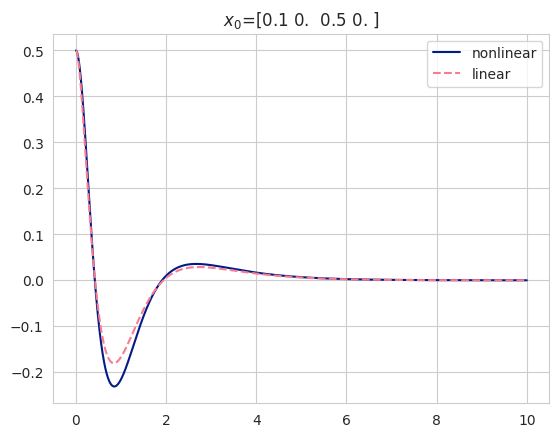

In [227]:
compare_comp(np.array([0.1, 0, 0.5, 0]))

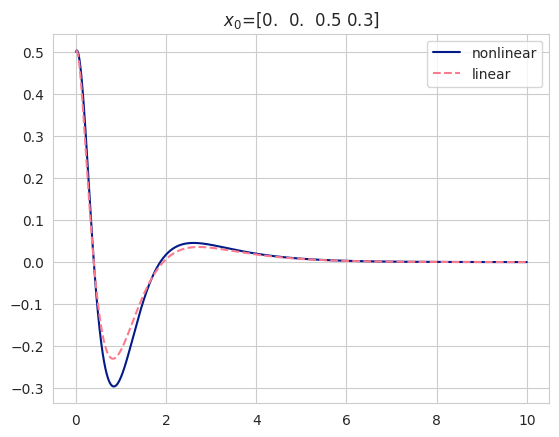

In [228]:
compare_comp(np.array([0, 0, 0.5, 0.3]))

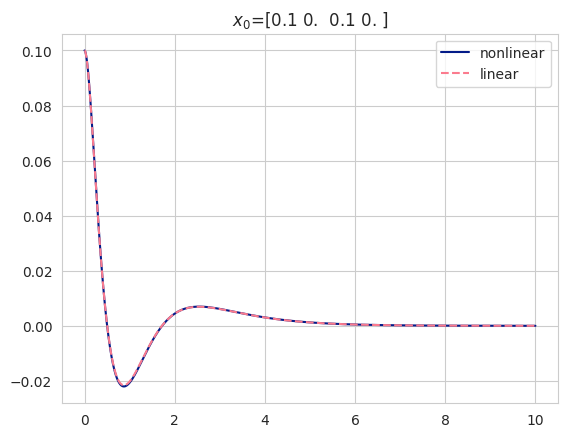

In [229]:
compare_comp(np.array([0.1, 0, 0.1, 0]))

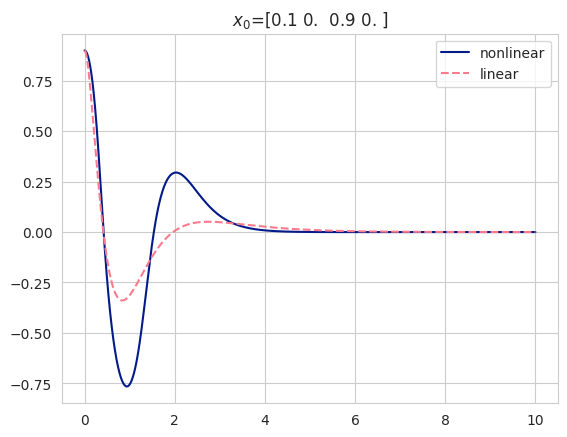

In [230]:
compare_comp(np.array([0.1, 0, 0.9, 0]))

6.2

In [231]:
A_1 = A

B_1 = B

B_2 = np.zeros((4,4))

A_2 = np.array([
    [0, 1, 0, 0],
    [-1, 0, 0, 0],
    [0, 0, 0, 2],
    [0, 0, -2, 0],
])

C_2 = np.array([[0, 0, 1, 0]])

D_2 = np.array([[0.1, 0.1, 0.1, 0.1]])

In [232]:
P_1 = cp.Variable((A_1.shape[0],D_2.shape[1]))
Y_1 = cp.Variable((B_1.shape[1],B_2.shape[1])) 
prob = cp.Problem(cp.Maximize(0),[C_2 @ P_1 + D_2 == 0, P_1 @ A_2 - A_1 @ P_1 == B_1 @ Y_1 + B_2])
prob.solve(solver="CLARABEL")

0.0

In [233]:
ts = get_t()
w_sys = ctrl.ss(A_2, np.zeros((4,1)), np.zeros((1, 4)), 0)
w = ctrl.initial_response(w_sys, X0=[0.5, 0.2, 0.5, 0.2], T=ts).states

In [234]:
Y = np.ones((B.shape[1], A.shape[0]))
G = np.diag([-1, -2, -3, -4])
K_1 = task32_get_K(A, B, G, Y)

new_g = Gs[0]
new_y = np.ones((A.shape[0], C.shape[0]))

K_2 = Y_1.value - K_1 @ P_1.value
K_2

array([[-5.,  3., -3., -2.]])

In [235]:
def up_func_track(t, x, u, params):
    w = u.copy()
    f = 0
    u = (K_1@x + K_2@w).reshape(-1)[0]
    dx = np.array([
        x[1],
        1 / (M + m*np.sin(x[2])**2) * (-m*l*np.sin(x[2])*x[3]**2 + m*g*np.cos(x[2])*np.sin(x[2]) + u + f*np.cos(x[2])/l),
        x[3],
        1 / (M + m*np.sin(x[2])**2) * (-m*np.cos(x[2])*np.sin(x[2])*x[3]**2 + (M+m)*g*np.sin(x[2])/l + (M+m)*f/(m*l**2) + u*np.cos(x[2])/l)
    ]) 
    return dx

In [238]:
def compare_track(x0):
    non_lin_sys_track = ctrl.NonlinearIOSystem(up_func_track)
    non_lin_sys_track.set_inputs(4)
    resp_non_lin_track= ctrl.input_output_response(non_lin_sys_track, T=ts, X0=x0, U=w)
    lin_sys_track = ctrl.ss(A_1 + B_1@K_1, B_2 + B_1@K_2, C_2, D_2)
    resp_lin_track= ctrl.input_output_response(lin_sys_track, T=ts, X0=x0, U=w)
    plt.plot(ts, -(D_2@w)[0], label="target")
    plt.plot(ts, resp_non_lin_track.states[2], label="nonlinear")
    plt.plot(ts, resp_lin_track.states[2], "--", label="linear")
    plt.title(f'$x_0$={x0}')
    plt.legend()
    plt.savefig(f'{SAVE_PATH}/task6_2_{x0[0]}_{x0[1]}_{x0[2]}_{x0[3]}.jpg')

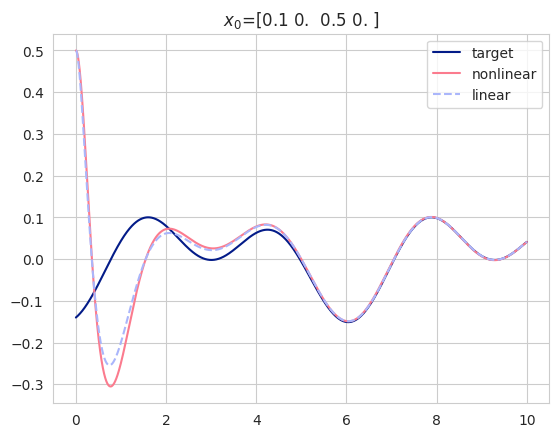

In [239]:
compare_track(np.array([0.1, 0, 0.5, 0]))

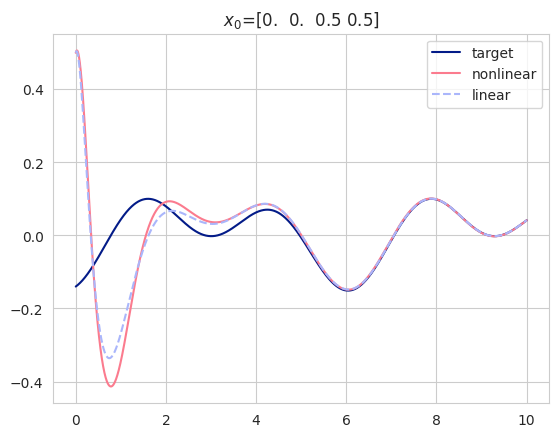

In [244]:
compare_track(np.array([0, 0, 0.5, 0.5]))

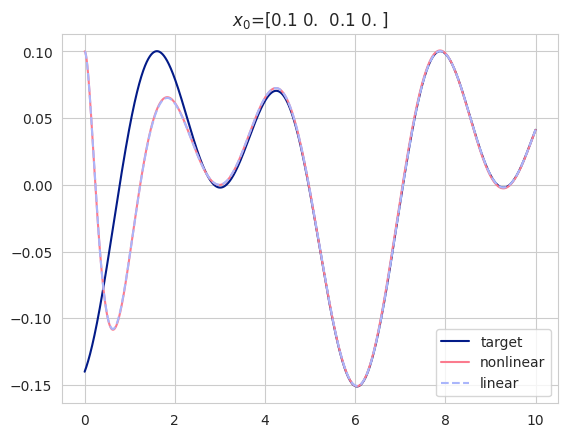

In [241]:
compare_track(np.array([0.1, 0, 0.1, 0]))

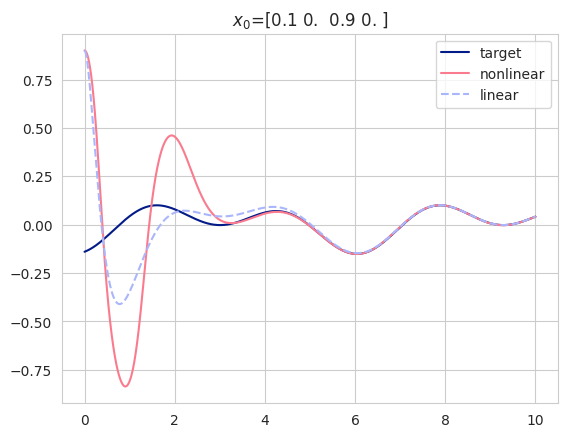

In [243]:
compare_track(np.array([0.1, 0, 0.9, 0]))